<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_55/443518264.py:13: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep='\s+', names=['head', 'relation', 'tail'])
/tmp/ipykernel_55/443518264.py:17: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep='\s+', names=['head', 'relation', 'tail'])


Total rows: 13821

First 5 rows:
      head      relation        tail
0  olivia0      sisterOf    selina10
1  olivia0      sisterOf  isabella11
2  olivia0      sisterOf     oskar24
3  olivia0      sisterOf       adam9
4  olivia0  secondAuntOf      lena18

Duplicate Triples Found: 0

Unique Relationship Types: 28
relation
grandsonOf            814
grandmotherOf         813
grandfatherOf         813
granddaughterOf       812
motherOf              733
fatherOf              733
sisterOf              636
daughterOf            628
greatGrandsonOf       624
greatGrandmotherOf    617
Name: count, dtype: int64


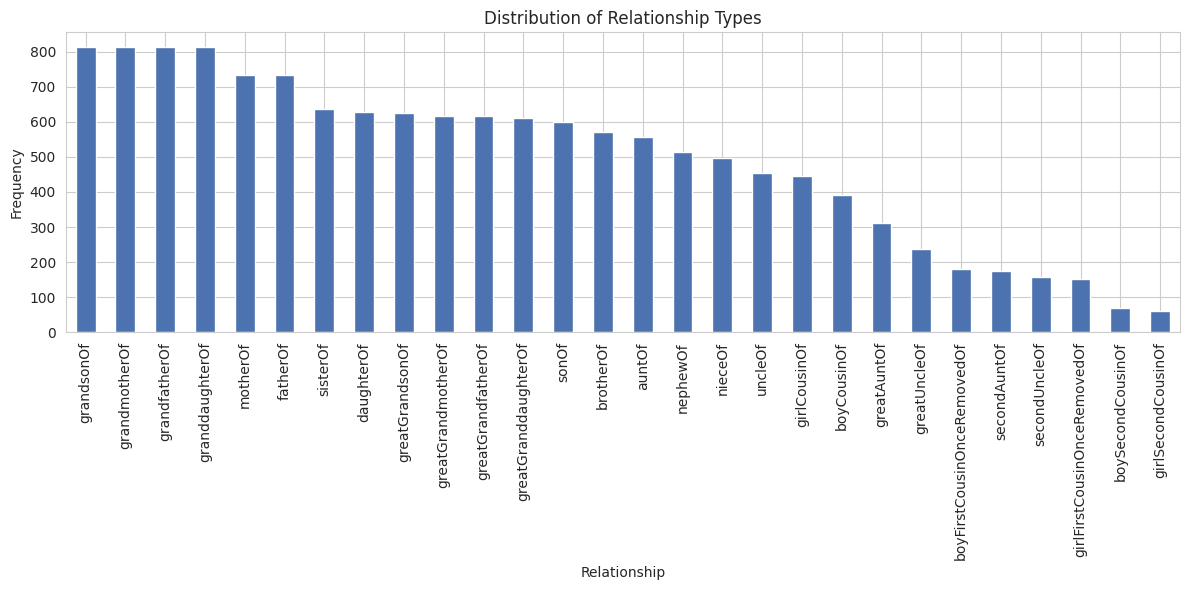

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better plots
sns.set_style("whitegrid")

# 1. Load the dataset
# We use Try-Except to handle different potentially running environments (Local VS Kaggle)
try:
    file_path = '/kaggle/input/train-txt/train.txt'
    df = pd.read_csv(file_path, sep='\s+', names=['head', 'relation', 'tail'])
except:
    # Fallback to local path if running locally
    file_path = '../The Problem/train.txt' 
    df = pd.read_csv(file_path, sep='\s+', names=['head', 'relation', 'tail'])

# 2. Basic Sanity Check
print(f"Total rows: {len(df)}")
print("\nFirst 5 rows:")
print(df.head())

# 3. Data Integrity: Check for Duplicates
duplicate_rows = df.duplicated().sum()
print(f"\nDuplicate Triples Found: {duplicate_rows}")
if duplicate_rows > 0:
    print("Dropping duplicates...")
    df = df.drop_duplicates()

# 4. Task Requirement: "What's the distribution of different relationships?" 
print(f"\nUnique Relationship Types: {df['relation'].nunique()}")
print(df['relation'].value_counts().head(10))

# Plot the distribution
plt.figure(figsize=(12, 6))
df['relation'].value_counts().plot(kind='bar', color='#4C72B0')
plt.title('Distribution of Relationship Types')
plt.ylabel('Frequency')
plt.xlabel('Relationship')
plt.tight_layout()
plt.show()

In [2]:
# Create a Directed Graph
G = nx.MultiDiGraph()

# Add edges from the dataframe
# zip() lets us iterate through the 3 columns simultaneously
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    G.add_edge(h, t, relation=r)

# Task Requirement: "How many people are there?" 
print(f"Number of Nodes (People): {G.number_of_nodes()}")
print(f"Number of Edges (Relationships): {G.number_of_edges()}")

# Check if the graph is connected (Can you reach everyone from everyone?)
# Since it's directed, we check "weakly connected" (ignoring direction) to see if it's one big family or islands.
print(f"Is the graph connected? {nx.is_weakly_connected(G)}")
print(f"Number of connected components: {nx.number_weakly_connected_components(G)}")

Number of Nodes (People): 1316
Number of Edges (Relationships): 13821
Is the graph connected? False
Number of connected components: 50



Component Size Distribution:
  Largest family: 27 people
  Smallest family: 26 people
  Median family size: 26 people
  Top 10 family sizes: [27, 27, 27, 27, 27, 27, 27, 27, 27, 27]


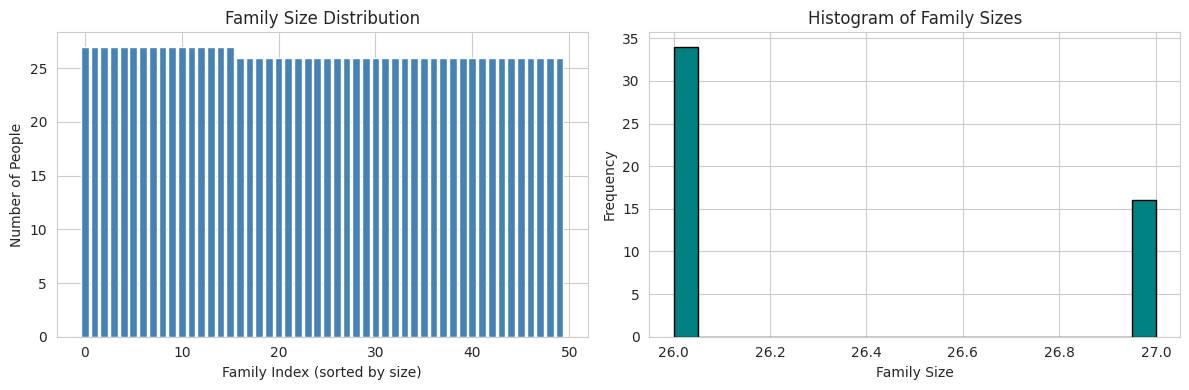

In [3]:
# --- Component Size Distribution ---
component_sizes = sorted([len(c) for c in nx.weakly_connected_components(G)], reverse=True)

print(f"\nComponent Size Distribution:")
print(f"  Largest family: {component_sizes[0]} people")
print(f"  Smallest family: {component_sizes[-1]} people")
print(f"  Median family size: {component_sizes[len(component_sizes)//2]} people")
print(f"  Top 10 family sizes: {component_sizes[:10]}")

# Visualize
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(range(len(component_sizes)), component_sizes, color='steelblue')
plt.xlabel("Family Index (sorted by size)")
plt.ylabel("Number of People")
plt.title("Family Size Distribution")

plt.subplot(1, 2, 2)
plt.hist(component_sizes, bins=20, color='teal', edgecolor='black')
plt.xlabel("Family Size")
plt.ylabel("Frequency")
plt.title("Histogram of Family Sizes")
plt.tight_layout()
plt.show()

In [4]:
# 1. Degree Centrality (Who has the most direct connections?)
degree_dict = dict(G.degree(G.nodes()))
sorted_degree = sorted(degree_dict.items(), key=lambda item: item[1], reverse=True)

print("Top 5 Most Connected People (Hubs):")
for node, degree in sorted_degree[:5]:
    print(f"{node}: {degree} connections")

# 2. Graph Density (How 'tight' is the family?)
density = nx.density(G)
print(f"\nGraph Density: {density:.6f}")
# Insight: Family trees are usually sparse (low density).

# 3. Diameter (Longest shortest path)
# Note: Diameter creates errors if the graph is disconnected.
# We calculate it on the largest component only.
largest_cc_nodes = max(nx.weakly_connected_components(G), key=len)
largest_subgraph = G.subgraph(largest_cc_nodes)

#This might be slow on 13k nodes. If it hangs, skip it.
try:
    # We treat it as undirected for 'family distance'
    diameter = nx.diameter(largest_subgraph.to_undirected())
    print(f"Diameter of the largest family cluster: {diameter}")
except Exception as e:
    print("Could not calculate diameter (graph might be too complex/disconnected)")

Top 5 Most Connected People (Hubs):
dominik1036: 45 connections
magdalena1044: 45 connections
oliver1045: 45 connections
lisa1035: 45 connections
oskar133: 44 connections

Graph Density: 0.007987
Diameter of the largest family cluster: 3


Visualizing the neighborhood of: dominik1036


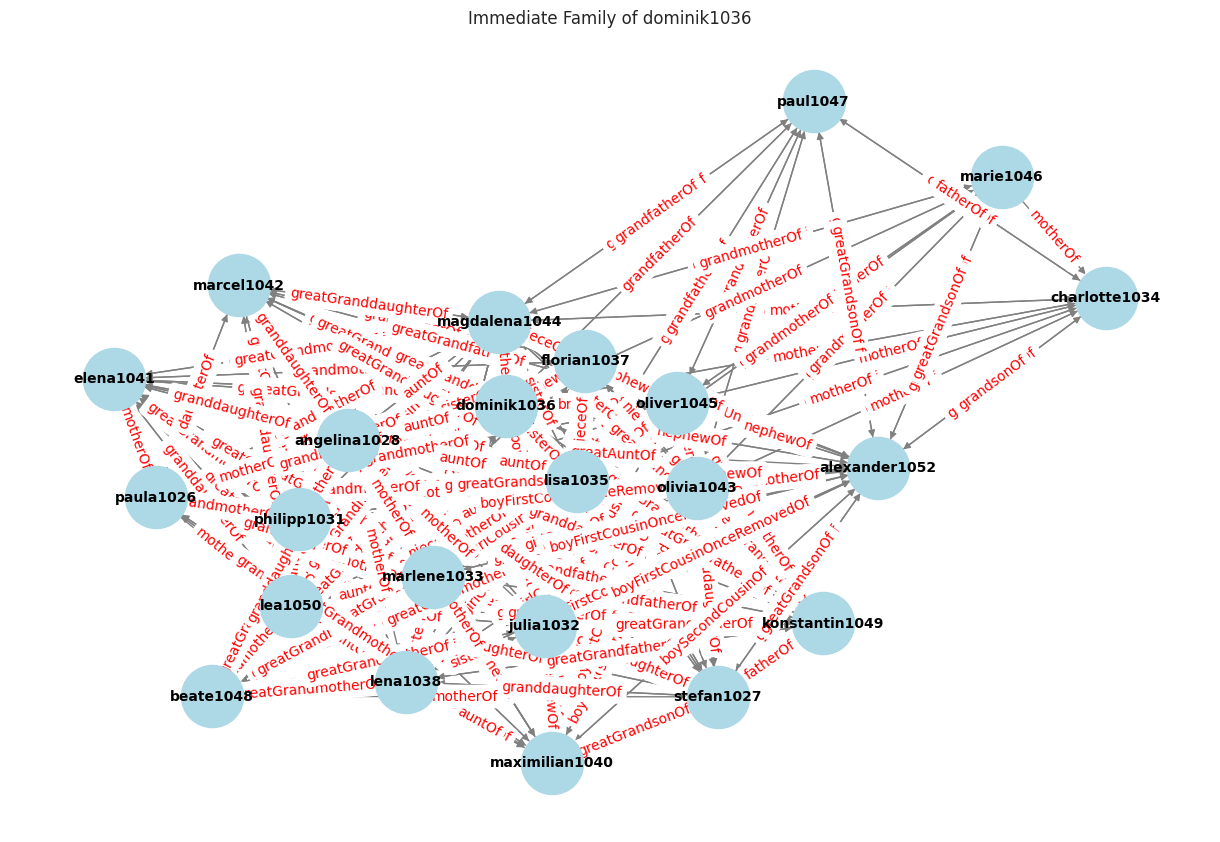

In [5]:
# Pick the most connected person 
center_node = sorted_degree[0][0] 
print(f"Visualizing the neighborhood of: {center_node}")

# Create a subgraph of just this person and their direct neighbors (Radius=1)
# Radius=2 will show neighbors of neighbors (grandparents/cousins)
subgraph = nx.ego_graph(G, center_node, radius=1)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # consistent layout

# Draw nodes and edges
nx.draw(subgraph, pos, with_labels=True, node_color='lightblue', 
        node_size=2000, font_size=10, font_weight='bold', edge_color='gray')

# Draw edge labels (relationships)
edge_labels = nx.get_edge_attributes(subgraph, 'relation')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_color='red')

plt.title(f"Immediate Family of {center_node}")
plt.show()

Found 495 ancestral roots (founding members).

Population by Generation:
0    495
1    215
2    192
3    206
4    146
5     55
6      7
Name: count, dtype: int64


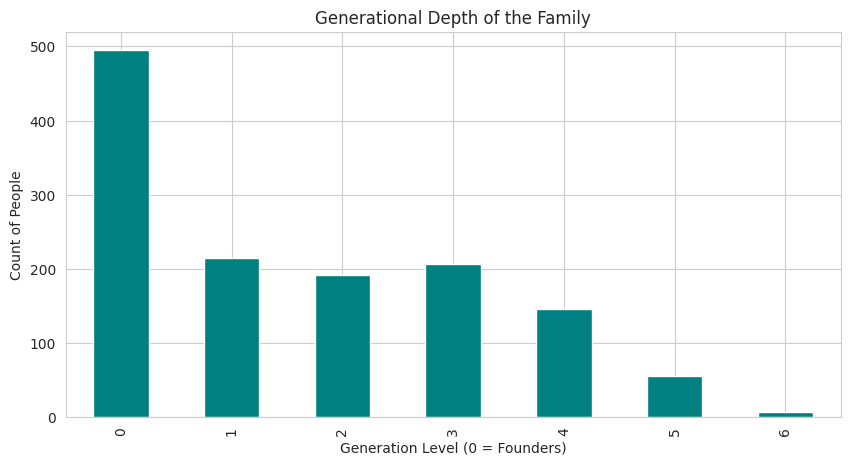

In [6]:
# --- ANALYSIS 1: Generation Detection ---
# Goal: Assign a 'Generation Level' to nodes based on parent/child links.

# 1. Filter for "Vertical" edges only
# We ignore "sisterOf" or "cousinOf" because they stay within the same generation.
# We only care about edges that move TIME forward or backward.
# Let's standardize: Parent -> Child edges.
vertical_relations = ['fatherOf', 'motherOf']
inverse_vertical = ['sonOf', 'daughterOf']

# Create a "Time Graph" (Parents pointing to Children)
time_graph = nx.DiGraph()
for u, v, data in G.edges(data=True):
    r = data['relation']
    if r in vertical_relations:
        time_graph.add_edge(u, v)  # Parent -> Child
    elif r in inverse_vertical:
        time_graph.add_edge(v, u)  # Child -> Parent (flip to Parent -> Child)

# 2. Find the "Ancestors" (Roots)
# These are people with 0 incoming edges in our Time Graph (No parents listed)
ancestors = [n for n in time_graph.nodes() if time_graph.in_degree(n) == 0]
print(f"Found {len(ancestors)} ancestral roots (founding members).")

# 3. Calculate Generations (Longest Path from an Ancestor)
# We use a topological sort approach or simple BFS/DFS layer count.
generations = {}
# Initialize ancestors as Generation 0
for root in ancestors:
    generations[root] = 0

# Propagate down
# Note: This is a simplification. A robust way is 'longest path' in a DAG.
for node in nx.topological_sort(time_graph):
    if node not in generations:
        parents = list(time_graph.predecessors(node))
        if parents:
            # You are 1 generation below your 'youngest' parent recorded
            parent_gens = [generations.get(p, 0) for p in parents]
            generations[node] = max(parent_gens) + 1
        else:
            generations[node] = 0

# 4. Visualization: The "Demographic Pyramid"
gen_counts = pd.Series(generations.values()).value_counts().sort_index()
print("\nPopulation by Generation:")
print(gen_counts)

plt.figure(figsize=(10, 5))
gen_counts.plot(kind='bar', color='teal')
plt.title("Generational Depth of the Family")
plt.xlabel("Generation Level (0 = Founders)")
plt.ylabel("Count of People")
plt.show()

Total nodes in time_graph: 1316
Total nodes in full graph: 1316
Nodes NOT in time_graph: 0

Relationships held by 'ancestors' (nodes with no parents recorded):
relation
grandmotherOf         520
grandfatherOf         489
greatGrandmotherOf    469
greatGrandfatherOf    457
motherOf              383
fatherOf              363
Name: count, dtype: int64

'Ancestors' who have grandchildren (so probably have missing parents): 381
True founding ancestors (no grandchildren): 114


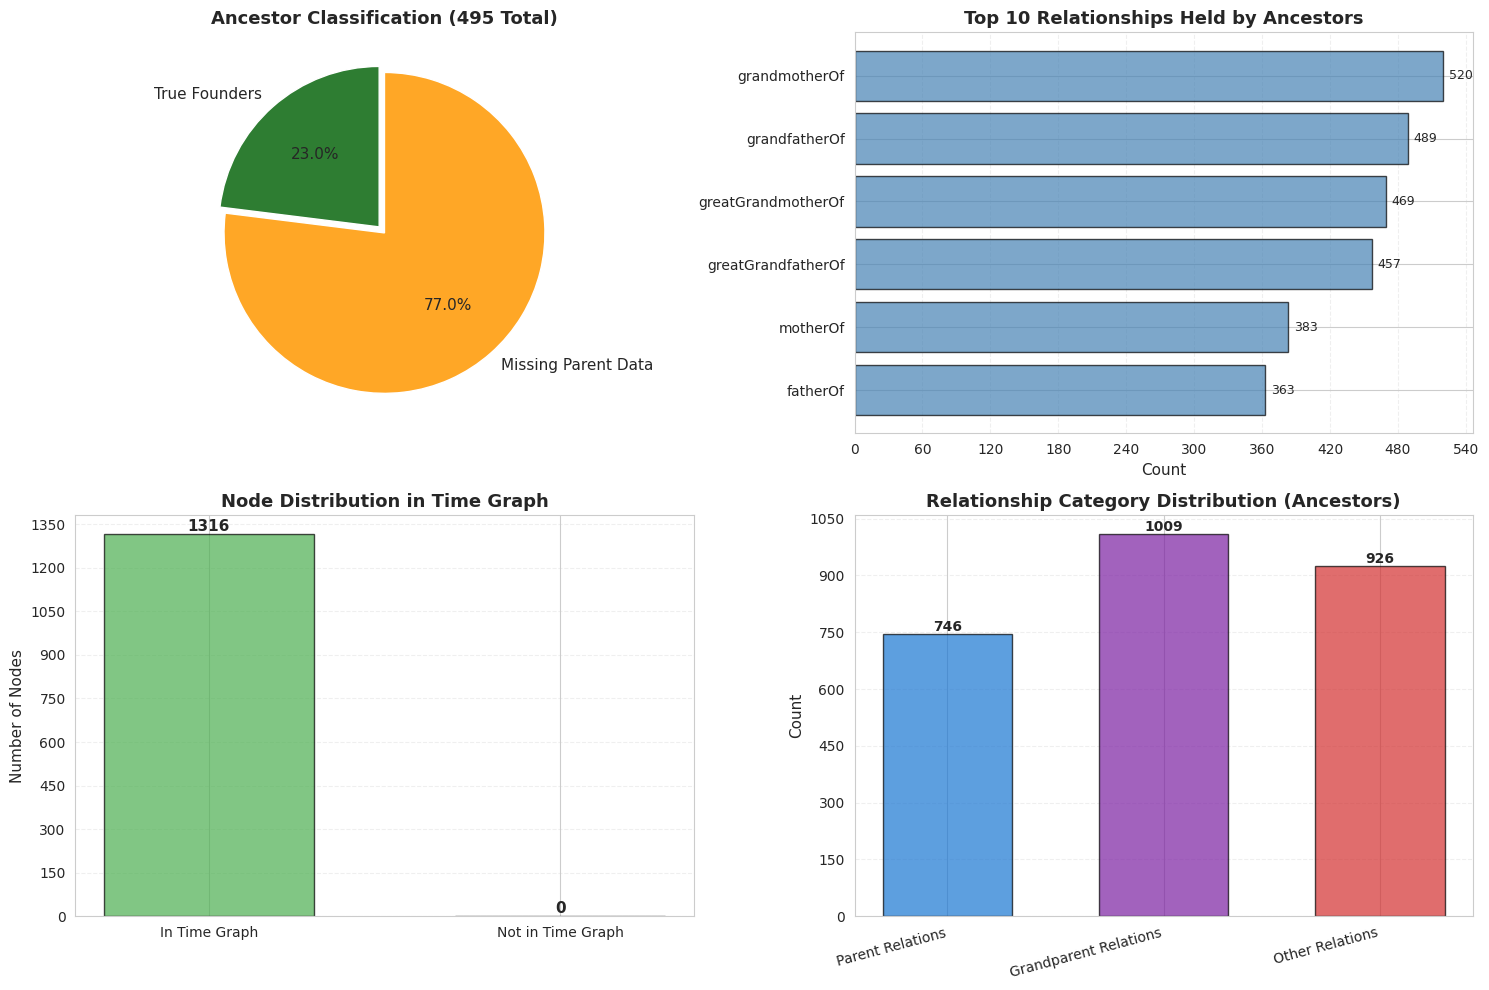


ANCESTOR ANALYSIS SUMMARY
Total ancestors (no parents recorded): 495
  - True founding ancestors: 114 (23.0%)
  - Ancestors with missing parent data: 381 (77.0%)

Data completeness:
  - Nodes in time graph: 1316/1316 (100.0%)
  - Missing from time graph: 0 (0.0%)


In [52]:
# --- INVESTIGATE: Why 495 ancestral roots? ---
# Let's understand who these "ancestors" are
print(f"Total nodes in time_graph: {time_graph.number_of_nodes()}")
print(f"Total nodes in full graph: {G.number_of_nodes()}")
print(f"Nodes NOT in time_graph: {G.number_of_nodes() - time_graph.number_of_nodes()}")

# Nodes with no parents in the data
ancestors = [n for n in time_graph.nodes() if time_graph.in_degree(n) == 0]

# What relationships DO these ancestors have?
ancestor_relations = df[df['head'].isin(ancestors)]['relation'].value_counts()
print(f"\nRelationships held by 'ancestors' (nodes with no parents recorded):")
print(ancestor_relations.head(15))

# Check: Are some "ancestors" actually middle-generation people with missing parent data?
# If someone is an "ancestor" but has grandchildren, their parents are just missing
ancestor_with_grandkids = []
for anc in ancestors:
    rels = df[df['head'] == anc]['relation'].tolist()
    if 'grandfatherOf' in rels or 'grandmotherOf' in rels:
        # They have grandkids, so they should have parents too (just missing)
        ancestor_with_grandkids.append(anc)

print(f"\n'Ancestors' who have grandchildren (so probably have missing parents): {len(ancestor_with_grandkids)}")
print(f"True founding ancestors (no grandchildren): {len(ancestors) - len(ancestor_with_grandkids)}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Ancestor Type Breakdown (Pie Chart)
ancestor_types = {
    'True Founders': len(ancestors) - len(ancestor_with_grandkids),
    'Missing Parent Data': len(ancestor_with_grandkids)
}
colors_pie = ['#2E7D32', '#FFA726']
explode = (0.05, 0)
axes[0,0].pie(ancestor_types.values(), labels=ancestor_types.keys(), autopct='%1.1f%%',
              startangle=90, colors=colors_pie, explode=explode, textprops={'fontsize': 11})
axes[0,0].set_title(f'Ancestor Classification ({len(ancestors)} Total)', fontsize=13, fontweight='bold')

# 2. Top Relationships of Ancestors (Horizontal Bar)
top_relations = ancestor_relations.head(10)
axes[0,1].barh(range(len(top_relations)), top_relations.values, color='steelblue', alpha=0.7, edgecolor='black')
axes[0,1].set_yticks(range(len(top_relations)))
axes[0,1].set_yticklabels(top_relations.index, fontsize=10)
axes[0,1].set_xlabel('Count', fontsize=11)
axes[0,1].set_title('Top 10 Relationships Held by Ancestors', fontsize=13, fontweight='bold')
axes[0,1].invert_yaxis()
axes[0,1].grid(axis='x', alpha=0.3, linestyle='--')
axes[0,1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Add value labels on bars
for i, v in enumerate(top_relations.values):
    axes[0,1].text(v + 5, i, str(v), va='center', fontsize=9)

# 3. Node Distribution Comparison
node_categories = {
    'In Time Graph': time_graph.number_of_nodes(),
    'Not in Time Graph': G.number_of_nodes() - time_graph.number_of_nodes()
}
bars = axes[1,0].bar(node_categories.keys(), node_categories.values(), 
                      color=['#4CAF50', '#FF5722'], alpha=0.7, edgecolor='black', width=0.6)
axes[1,0].set_ylabel('Number of Nodes', fontsize=11)
axes[1,0].set_title('Node Distribution in Time Graph', fontsize=13, fontweight='bold')
axes[1,0].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1,0].grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=11, fontweight='bold')

# 4. Relationship Type Distribution for Ancestors
relation_categories = {
    'Parent Relations': ancestor_relations.get('fatherOf', 0) + ancestor_relations.get('motherOf', 0),
    'Grandparent Relations': ancestor_relations.get('grandfatherOf', 0) + ancestor_relations.get('grandmotherOf', 0),
    'Other Relations': ancestor_relations.drop(['fatherOf', 'motherOf', 'grandfatherOf', 'grandmotherOf'], errors='ignore').sum()
}
colors_bar = ['#1976D2', '#7B1FA2', '#D32F2F']
bars2 = axes[1,1].bar(range(len(relation_categories)), relation_categories.values(), 
                       color=colors_bar, alpha=0.7, edgecolor='black', width=0.6)
axes[1,1].set_xticks(range(len(relation_categories)))
axes[1,1].set_xticklabels(relation_categories.keys(), fontsize=10, rotation=15, ha='right')
axes[1,1].set_ylabel('Count', fontsize=11)
axes[1,1].set_title('Relationship Category Distribution (Ancestors)', fontsize=13, fontweight='bold')
axes[1,1].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1,1].grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar in bars2:
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Additional summary statistics
print("\n" + "="*60)
print("ANCESTOR ANALYSIS SUMMARY")
print("="*60)
print(f"Total ancestors (no parents recorded): {len(ancestors)}")
print(f"  - True founding ancestors: {len(ancestors) - len(ancestor_with_grandkids)} ({(len(ancestors) - len(ancestor_with_grandkids))/len(ancestors)*100:.1f}%)")
print(f"  - Ancestors with missing parent data: {len(ancestor_with_grandkids)} ({len(ancestor_with_grandkids)/len(ancestors)*100:.1f}%)")
print(f"\nData completeness:")
print(f"  - Nodes in time graph: {time_graph.number_of_nodes()}/{G.number_of_nodes()} ({time_graph.number_of_nodes()/G.number_of_nodes()*100:.1f}%)")
print(f"  - Missing from time graph: {G.number_of_nodes() - time_graph.number_of_nodes()} ({(G.number_of_nodes() - time_graph.number_of_nodes())/G.number_of_nodes()*100:.1f}%)")

Inferred gender for 1316 nodes.
Male count: 646
Female count: 670

Data Quality Check Passed: No gender contradictions found.


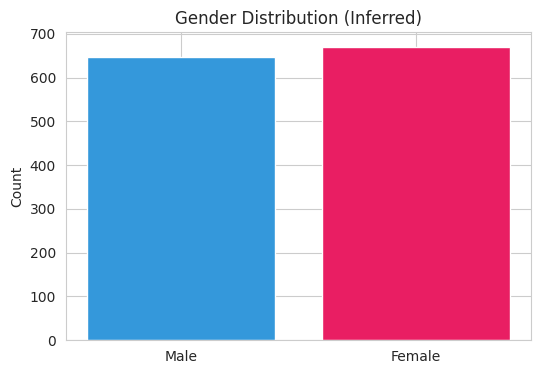

In [8]:
# --- ANALYSIS 2: Gender Inference & Consistency ---
# Goal: Infer gender from relationship labels and find data errors.

male_relations = {'fatherOf', 'brotherOf', 'sonOf', 'uncleOf', 'nephewOf', 'grandfatherOf', 'grandsonOf'}
female_relations = {'motherOf', 'sisterOf', 'daughterOf', 'auntOf', 'nieceOf', 'grandmotherOf', 'granddaughterOf'}

inferred_gender = {}
conflicts = []

for u, v, data in G.edges(data=True):
    r = data['relation']
    
    # Check Source (u)
    if r in male_relations:
        if inferred_gender.get(u) == 'F': conflicts.append((u, 'Expected M, was F'))
        inferred_gender[u] = 'M'
    elif r in female_relations:
        if inferred_gender.get(u) == 'M': conflicts.append((u, 'Expected F, was M'))
        inferred_gender[u] = 'F'

print(f"Inferred gender for {len(inferred_gender)} nodes.")
male_count = list(inferred_gender.values()).count('M')
female_count = list(inferred_gender.values()).count('F')
print(f"Male count: {male_count}")
print(f"Female count: {female_count}")

if conflicts:
    print(f"\nCRITICAL DATA ERROR: Found {len(conflicts)} gender contradictions!")
    print(conflicts[:5])
else:
    print("\nData Quality Check Passed: No gender contradictions found.")

# Visualize Gender Distribution
plt.figure(figsize=(6, 4))
plt.bar(['Male', 'Female'], [male_count, female_count], color=['#3498db', '#e91e63'])
plt.title('Gender Distribution (Inferred)')
plt.ylabel('Count')
plt.show()

In [9]:
# --- CORRECTED: Cycle Analysis (Only on Parent-Child "Time Graph") ---
# Cycles in the FULL graph are expected (siblings are symmetric: A sisterOf B, B sisterOf A)
# We only care about cycles in the TIME GRAPH (would mean someone is their own ancestor)

# Using time_graph from Cell 5
try:
    cycles = list(nx.find_cycle(time_graph, orientation='original'))
    print(f"TEMPORAL PARADOX: Found a cycle in parent-child relationships! {cycles[:3]}")
except nx.NetworkXNoCycle:
    print("Temporal Logic Verified: No one is their own ancestor.")

# NEW: Let's understand the symmetric relationships properly
symmetric_relations = ['sisterOf', 'brotherOf', 'boyCousinOf', 'girlCousinOf']
symmetric_edges = df[df['relation'].isin(symmetric_relations)]
print(f"\nSymmetric relationship edges: {len(symmetric_edges)}")
print("These create 'cycles' in the full graph, which is expected behavior.")

Temporal Logic Verified: No one is their own ancestor.

Symmetric relationship edges: 2042
These create 'cycles' in the full graph, which is expected behavior.


In [10]:
# --- KNOWLEDGE GRAPH VALIDATION: Reciprocity Check ---
# If (A, fatherOf, B) exists, does (B, sonOf, A) or (B, daughterOf, A) exist?

reciprocal_map = {
    'fatherOf': ['sonOf', 'daughterOf'],
    'motherOf': ['sonOf', 'daughterOf'],
    'sonOf': ['fatherOf', 'motherOf'],
    'daughterOf': ['fatherOf', 'motherOf'],
    'brotherOf': ['brotherOf', 'sisterOf'],
    'sisterOf': ['brotherOf', 'sisterOf'],
    'grandfatherOf': ['grandsonOf', 'granddaughterOf'],
    'grandmotherOf': ['grandsonOf', 'granddaughterOf'],
    'grandsonOf': ['grandfatherOf', 'grandmotherOf'],
    'granddaughterOf': ['grandfatherOf', 'grandmotherOf'],
    'uncleOf': ['nephewOf', 'nieceOf'],
    'auntOf': ['nephewOf', 'nieceOf'],
    'nephewOf': ['uncleOf', 'auntOf'],
    'nieceOf': ['uncleOf', 'auntOf'],
}

# Build edge lookup for fast checking
edge_set = set(zip(df['head'], df['relation'], df['tail']))

missing_reciprocals = []
checked = 0
for h, r, t in edge_set:
    if r in reciprocal_map:
        checked += 1
        expected_relations = reciprocal_map[r]
        found = any((t, exp_r, h) in edge_set for exp_r in expected_relations)
        if not found:
            missing_reciprocals.append((h, r, t))

print(f"Checked {checked} edges with expected reciprocals")
print(f"Missing reciprocal edges: {len(missing_reciprocals)}")
print(f"Reciprocity Rate: {100 * (1 - len(missing_reciprocals)/checked):.2f}%")

if missing_reciprocals:
    print(f"\nExamples of missing reciprocals:")
    for edge in missing_reciprocals[:10]:
        print(f"  {edge[0]} --{edge[1]}--> {edge[2]} (reverse not found)")

Checked 9172 edges with expected reciprocals
Missing reciprocal edges: 590
Reciprocity Rate: 93.57%

Examples of missing reciprocals:
  elias878 --fatherOf--> jan874 (reverse not found)
  stefan527 --sonOf--> felix525 (reverse not found)
  marlene40 --daughterOf--> raphael29 (reverse not found)
  paula1026 --motherOf--> florian1037 (reverse not found)
  anastasia1101 --motherOf--> thomas1091 (reverse not found)
  emilia415 --daughterOf--> vanessa394 (reverse not found)
  alexander195 --sonOf--> elias190 (reverse not found)
  elena696 --motherOf--> julia699 (reverse not found)
  benjamin710 --fatherOf--> christian712 (reverse not found)
  lena434 --daughterOf--> leon427 (reverse not found)


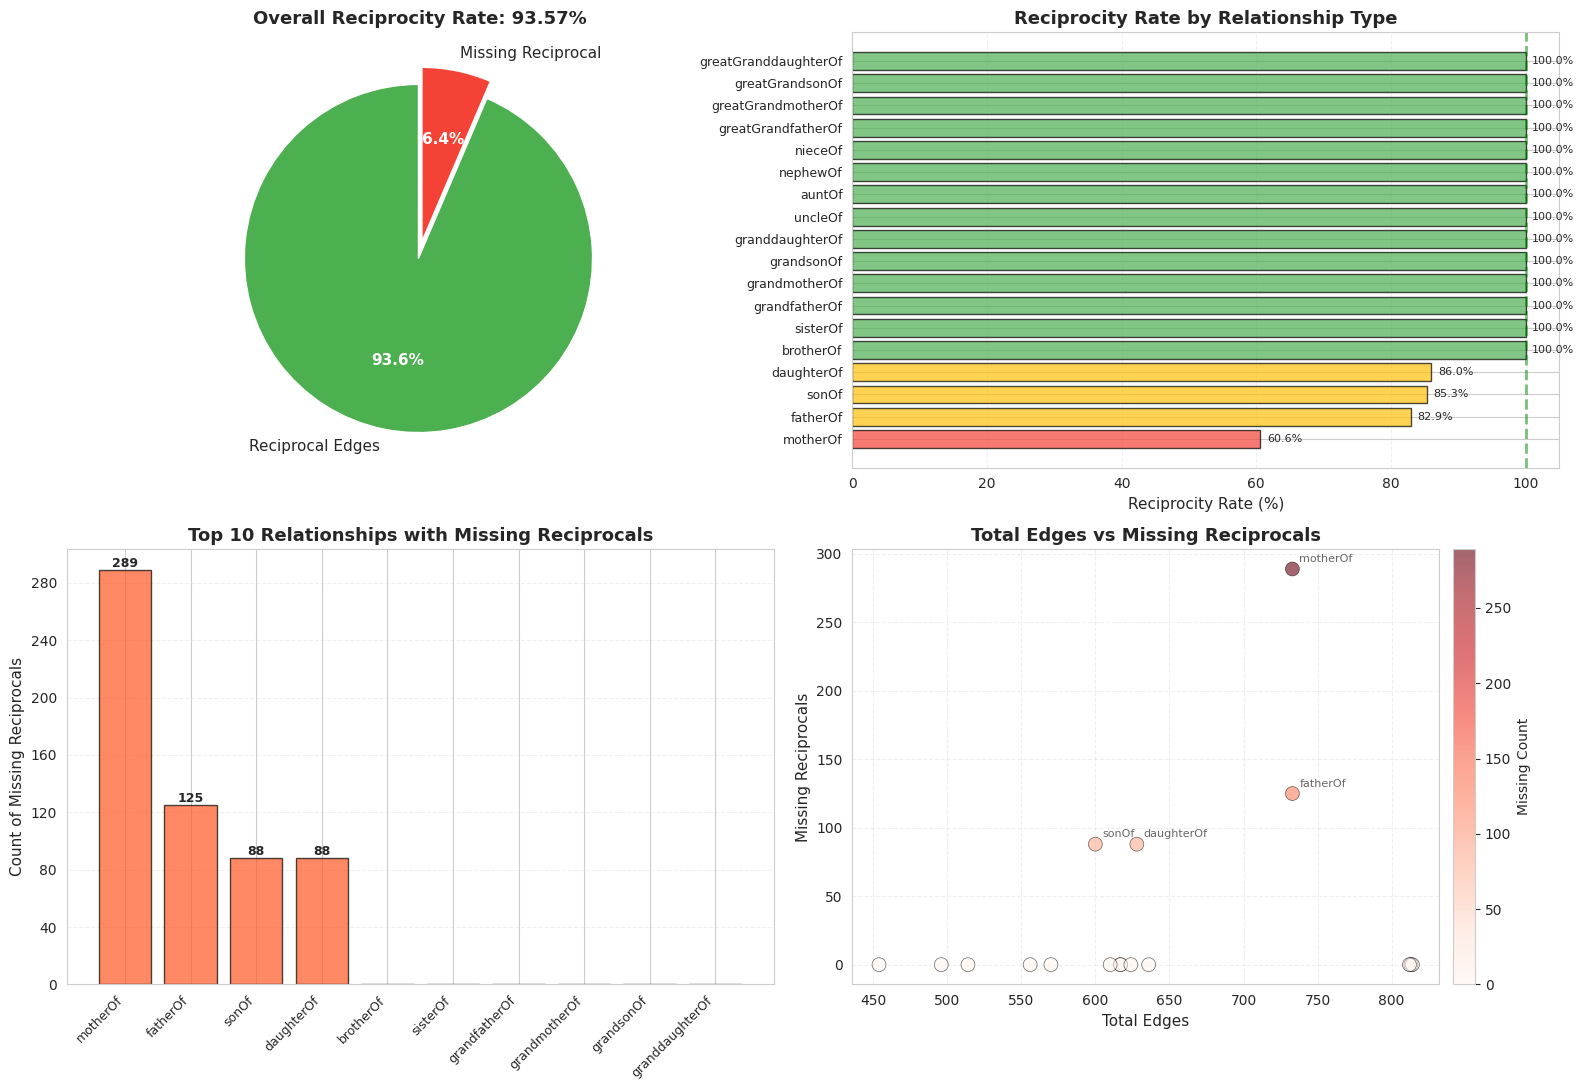

In [53]:
# --- RECIPROCITY VISUALIZATION ---
import matplotlib.pyplot as plt
import numpy as np

# Calculate reciprocity statistics by relationship type
reciprocity_by_relation = {}
for relation, reciprocals in reciprocal_map.items():
    edges_with_relation = [(h, r, t) for h, r, t in edge_set if r == relation]
    if edges_with_relation:
        missing_count = sum(1 for h, r, t in edges_with_relation 
                           if not any((t, exp_r, h) in edge_set for exp_r in reciprocals))
        total_count = len(edges_with_relation)
        reciprocity_rate = 100 * (1 - missing_count / total_count)
        reciprocity_by_relation[relation] = {
            'total': total_count,
            'missing': missing_count,
            'rate': reciprocity_rate
        }

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 11))

# 1. Overall Reciprocity (Pie Chart)
reciprocal_data = {
    'Reciprocal Edges': checked - len(missing_reciprocals),
    'Missing Reciprocal': len(missing_reciprocals)
}
colors_pie = ['#4CAF50', '#F44336']
explode = (0.05, 0.05)
wedges, texts, autotexts = axes[0,0].pie(reciprocal_data.values(), labels=reciprocal_data.keys(), 
                                          autopct='%1.1f%%', startangle=90, colors=colors_pie, 
                                          explode=explode, textprops={'fontsize': 11})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
axes[0,0].set_title(f'Overall Reciprocity Rate: {100 * (1 - len(missing_reciprocals)/checked):.2f}%', 
                    fontsize=13, fontweight='bold')

# 2. Reciprocity Rate by Relationship Type (Horizontal Bar)
sorted_relations = sorted(reciprocity_by_relation.items(), key=lambda x: x[1]['rate'])
relation_names = [r[0] for r in sorted_relations]
rates = [r[1]['rate'] for r in sorted_relations]

# Color bars based on rate (green for high, red for low)
bar_colors = ['#4CAF50' if rate > 95 else '#FFC107' if rate > 80 else '#F44336' for rate in rates]

axes[0,1].barh(range(len(relation_names)), rates, color=bar_colors, alpha=0.7, edgecolor='black')
axes[0,1].set_yticks(range(len(relation_names)))
axes[0,1].set_yticklabels(relation_names, fontsize=9)
axes[0,1].set_xlabel('Reciprocity Rate (%)', fontsize=11)
axes[0,1].set_title('Reciprocity Rate by Relationship Type', fontsize=13, fontweight='bold')
axes[0,1].set_xlim(0, 105)
axes[0,1].grid(axis='x', alpha=0.3, linestyle='--')
axes[0,1].axvline(100, color='green', linestyle='--', linewidth=2, alpha=0.5, label='100%')

# Add value labels
for i, (rate, rel_name) in enumerate(zip(rates, relation_names)):
    axes[0,1].text(rate + 1, i, f'{rate:.1f}%', va='center', fontsize=8)

# 3. Missing Reciprocals Count by Relationship (Bar Chart)
sorted_by_missing = sorted(reciprocity_by_relation.items(), key=lambda x: x[1]['missing'], reverse=True)
top_missing = sorted_by_missing[:10]  # Top 10 relationships with most missing reciprocals
missing_names = [r[0] for r in top_missing]
missing_counts = [r[1]['missing'] for r in top_missing]

bars = axes[1,0].bar(range(len(missing_names)), missing_counts, 
                     color='#FF5722', alpha=0.7, edgecolor='black')
axes[1,0].set_xticks(range(len(missing_names)))
axes[1,0].set_xticklabels(missing_names, fontsize=9, rotation=45, ha='right')
axes[1,0].set_ylabel('Count of Missing Reciprocals', fontsize=11)
axes[1,0].set_title('Top 10 Relationships with Missing Reciprocals', fontsize=13, fontweight='bold')
axes[1,0].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1,0].grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for bar in bars:
    height = bar.get_height()
    if height > 0:
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}',
                       ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4. Edge Count vs Missing Count (Scatter Plot)
total_counts = [r[1]['total'] for r in reciprocity_by_relation.items()]
missing_counts_all = [r[1]['missing'] for r in reciprocity_by_relation.items()]
relation_labels = [r[0] for r in reciprocity_by_relation.items()]

scatter = axes[1,1].scatter(total_counts, missing_counts_all, s=100, alpha=0.6, 
                           c=missing_counts_all, cmap='Reds', edgecolors='black', linewidth=0.5)
axes[1,1].set_xlabel('Total Edges', fontsize=11)
axes[1,1].set_ylabel('Missing Reciprocals', fontsize=11)
axes[1,1].set_title('Total Edges vs Missing Reciprocals', fontsize=13, fontweight='bold')
axes[1,1].grid(alpha=0.3, linestyle='--')

# Add labels for points with many missing reciprocals
for i, (x, y, label) in enumerate(zip(total_counts, missing_counts_all, relation_labels)):
    if y > 5:  # Only label points with more than 5 missing
        axes[1,1].annotate(label, (x, y), fontsize=8, alpha=0.7, 
                          xytext=(5, 5), textcoords='offset points')

# Add colorbar
cbar = plt.colorbar(scatter, ax=axes[1,1], pad=0.02)
cbar.set_label('Missing Count', fontsize=10)

plt.tight_layout()
plt.show()

In [11]:
# --- TRANSITIVITY RULES: Does the KG follow family logic? ---
# Rule: If A fatherOf B AND B fatherOf C, then A grandfatherOf C should exist

transitivity_rules = [
    (['fatherOf', 'motherOf'], ['fatherOf', 'motherOf'], 'grandfatherOf', 'grandmotherOf'),
    (['fatherOf', 'motherOf'], ['sonOf', 'daughterOf'], 'brotherOf', 'sisterOf'),  # siblings
]

# Check Rule 1: Parent of Parent = Grandparent
parent_rels = ['fatherOf', 'motherOf']
grandparent_rels = ['grandfatherOf', 'grandmotherOf']

# Build lookup: who are the children of each person?
children_of = {}
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    if r in parent_rels:
        if h not in children_of:
            children_of[h] = []
        children_of[h].append(t)

# Check transitivity
expected_grandparent_edges = 0
found_grandparent_edges = 0

for grandparent, parents in children_of.items():
    for parent in parents:
        if parent in children_of:
            grandchildren = children_of[parent]
            for grandchild in grandchildren:
                expected_grandparent_edges += 1
                # Check if grandparent -> grandchild edge exists
                for gp_rel in grandparent_rels:
                    if (grandparent, gp_rel, grandchild) in edge_set:
                        found_grandparent_edges += 1
                        break

print(f"Transitivity Check: Grandparent Relationships")
print(f"  Expected grandparent edges (based on parent chains): {expected_grandparent_edges}")
print(f"  Found grandparent edges: {found_grandparent_edges}")
print(f"  Transitivity Completeness: {100*found_grandparent_edges/max(1,expected_grandparent_edges):.2f}%")

Transitivity Check: Grandparent Relationships
  Expected grandparent edges (based on parent chains): 1294
  Found grandparent edges: 1294
  Transitivity Completeness: 100.00%


In [12]:
G = nx.DiGraph()# Create a Directed Graph

# Add edges from the dataframe
# zip() lets us iterate through the 3 columns simultaneously
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    G.add_edge(h, t, relation=r)

# Task Requirement: "How many people are there?" [cite: 68]
print(f"Number of Nodes (People): {G.number_of_nodes()}")
print(f"Number of Edges (Relationships): {G.number_of_edges()}")

# Check if the graph is connected (Can you reach everyone from everyone?)
# Since it's directed, we check "weakly connected" (ignoring direction) to see if it's one big family or islands.
print(f"Is the graph connected? {nx.is_weakly_connected(G)}")
print(f"Number of connected components: {nx.number_weakly_connected_components(G)}")

Number of Nodes (People): 1316
Number of Edges (Relationships): 13821
Is the graph connected? False
Number of connected components: 50


In [13]:
# --- CLUSTERING COEFFICIENT (Explicitly required by the task) ---
# Convert to undirected for clustering analysis
G_undirected = G.to_undirected()

# Global clustering coefficient
global_clustering = nx.transitivity(G_undirected)
print(f"Global Clustering Coefficient: {global_clustering:.4f}")

# Average local clustering
avg_local_clustering = nx.average_clustering(G_undirected)
print(f"Average Local Clustering Coefficient: {avg_local_clustering:.4f}")

# Compare to a random graph with same nodes/edges
n, m = G.number_of_nodes(), G.number_of_edges()
random_graph = nx.gnm_random_graph(n, m)
random_clustering = nx.transitivity(random_graph)
print(f"\nRandom Graph Clustering (same n, m): {random_clustering:.4f}")
print(f"Family graph is {global_clustering/max(random_clustering, 0.0001):.1f}x more clustered than random")

# Interpretation
print("\nInterpretation:")
if global_clustering > 0.3:
    print("  High clustering: Family members form tight-knit groups (expected for families)")
elif global_clustering > 0.1:
    print("  Moderate clustering: Some family groupings visible")
else:
    print("  Low clustering: Relationships are more spread out")

Global Clustering Coefficient: 0.7696
Average Local Clustering Coefficient: 0.7908

Random Graph Clustering (same n, m): 0.0152
Family graph is 50.5x more clustered than random

Interpretation:
  High clustering: Family members form tight-knit groups (expected for families)


In-Degree Stats (edges pointing TO a person):
  Mean: 10.50
  Max: 23 (node: dominik1036)

Out-Degree Stats (edges FROM a person):
  Mean: 10.50
  Max: 22 (node: oskar133)


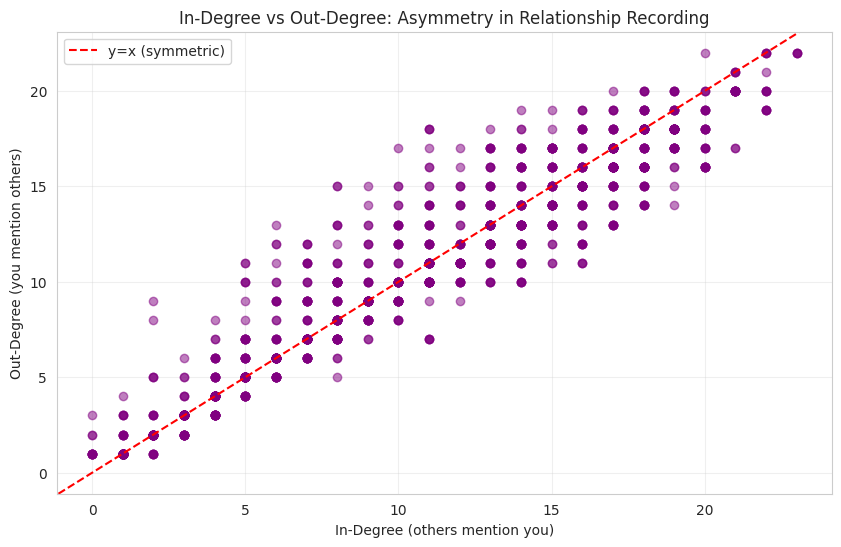


Most 'Outward' nodes (mention others more than being mentioned):
  sophie309: out-in = 7
  konstantin493: out-in = 7
  sarah592: out-in = 7
  charlotte624: out-in = 7
  thomas1214: out-in = 7

Most 'Inward' nodes (mentioned more than they mention):
  natalie811: out-in = -5
  simon1197: out-in = -5
  vanessa1200: out-in = -5
  stefan1192: out-in = -5
  rene112: out-in = -4


In [14]:
# --- DIRECTED GRAPH ANALYSIS: In-Degree vs Out-Degree ---
in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

in_deg_values = list(in_degrees.values())
out_deg_values = list(out_degrees.values())

print("In-Degree Stats (edges pointing TO a person):")
print(f"  Mean: {sum(in_deg_values)/len(in_deg_values):.2f}")
print(f"  Max: {max(in_deg_values)} (node: {max(in_degrees, key=in_degrees.get)})")

print("\nOut-Degree Stats (edges FROM a person):")
print(f"  Mean: {sum(out_deg_values)/len(out_deg_values):.2f}")
print(f"  Max: {max(out_deg_values)} (node: {max(out_degrees, key=out_degrees.get)})")

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(in_deg_values, out_deg_values, alpha=0.5, c='purple')
plt.xlabel("In-Degree (others mention you)")
plt.ylabel("Out-Degree (you mention others)")
plt.title("In-Degree vs Out-Degree: Asymmetry in Relationship Recording")
plt.axline((0, 0), slope=1, color='red', linestyle='--', label='y=x (symmetric)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find asymmetric nodes (mentioned a lot but don't mention others, or vice versa)
asymmetry = {n: out_degrees[n] - in_degrees[n] for n in G.nodes()}
most_outward = sorted(asymmetry.items(), key=lambda x: x[1], reverse=True)[:5]
most_inward = sorted(asymmetry.items(), key=lambda x: x[1])[:5]

print("\nMost 'Outward' nodes (mention others more than being mentioned):")
for node, diff in most_outward:
    print(f"  {node}: out-in = {diff}")
    
print("\nMost 'Inward' nodes (mentioned more than they mention):")
for node, diff in most_inward:
    print(f"  {node}: out-in = {diff}")

Number of sibling groups (2+ children): 221
Average siblings per group: 2.70
Largest sibling group: 5 children
Members of largest sibling group: {'oskar24', 'olivia0', 'adam9', 'isabella11', 'selina10'}


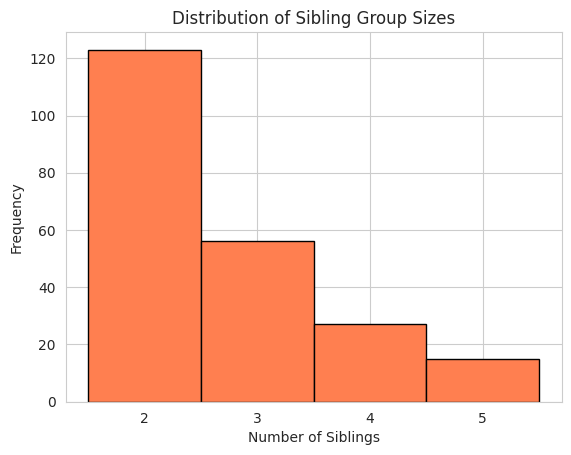

In [30]:
# --- FAMILY-SPECIFIC: Sibling Group Analysis ---
# Find all sibling groups (people who share a parent)

from collections import defaultdict

# Map each person to their parents
parents_of = defaultdict(set)
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    if r in ['fatherOf', 'motherOf']:
        parents_of[t].add(h)
    elif r in ['sonOf', 'daughterOf']:
        parents_of[h].add(t)

# Group children by parent sets
parent_to_children = defaultdict(set)
for child, parents in parents_of.items():
    parent_key = tuple(sorted(parents))
    if parent_key:  # Has at least one parent
        parent_to_children[parent_key].add(child)

# Analyze sibling group sizes
sibling_groups = [children for children in parent_to_children.values() if len(children) > 1]
sibling_sizes = [len(g) for g in sibling_groups]

print(f"Number of sibling groups (2+ children): {len(sibling_groups)}")
if sibling_sizes:
    print(f"Average siblings per group: {sum(sibling_sizes)/len(sibling_sizes):.2f}")
    print(f"Largest sibling group: {max(sibling_sizes)} children")
    
    # Find the largest sibling group
    largest_group = max(sibling_groups, key=len)
    print(f"Members of largest sibling group: {largest_group}")
    # Adjust the bins to be centered
    bin_edges = range(2, max(sibling_sizes) + 2)  # Define bins for each sibling group size
    plt.hist(sibling_sizes, bins=bin_edges, edgecolor='black', color='coral')

    # Adjust xticks to align with the center of each bar
    bin_centers = [x + 0.5 for x in range(2, max(sibling_sizes) + 1)]
    plt.xticks(bin_centers, labels=range(2, max(sibling_sizes) + 1))
    plt.xlabel("Number of Siblings")
    plt.ylabel("Frequency")
    plt.title("Distribution of Sibling Group Sizes")
    plt.show()

Largest family component: 27 people
Average path length: 1.470
  → On average, any two people are ~1.5 relationships apart
Diameter: 3
  → The most distant relatives are 3 steps apart
Radius: 2
Center nodes (most 'central' family members): ['johanna22', 'adam9', 'nico4', 'fabian26', 'luis14']...


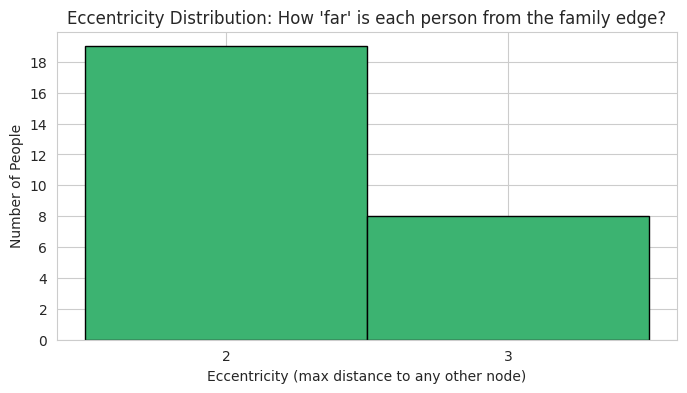

In [41]:
# --- PATH LENGTH ANALYSIS ---
# Compute on largest component (undirected for "family distance")
largest_cc = max(nx.weakly_connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).to_undirected()
print(f"Largest family component: {G_largest.number_of_nodes()} people")
# Average shortest path length
avg_path = nx.average_shortest_path_length(G_largest)
print(f"Average path length: {avg_path:.3f}")
print(f"  → On average, any two people are ~{avg_path:.1f} relationships apart")
# Diameter (we already computed this, but let's add context)
diameter = nx.diameter(G_largest)
print(f"Diameter: {diameter}")
print(f"  → The most distant relatives are {diameter} steps apart")
# Radius and Center
radius = nx.radius(G_largest)
center_nodes = nx.center(G_largest)
print(f"Radius: {radius}")
print(f"Center nodes (most 'central' family members): {center_nodes[:5]}...")
# Eccentricity distribution
eccentricity = nx.eccentricity(G_largest)
ecc_values = list(eccentricity.values())
plt.figure(figsize=(8, 4))
plt.hist(ecc_values, bins=range(min(ecc_values), max(ecc_values)+2), edgecolor='black', color='mediumseagreen', align='left')
plt.xticks(range(min(ecc_values), max(ecc_values)+1))
plt.xlabel("Eccentricity (max distance to any other node)")
plt.ylabel("Number of People")
plt.title("Eccentricity Distribution: How 'far' is each person from the family edge?")
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()

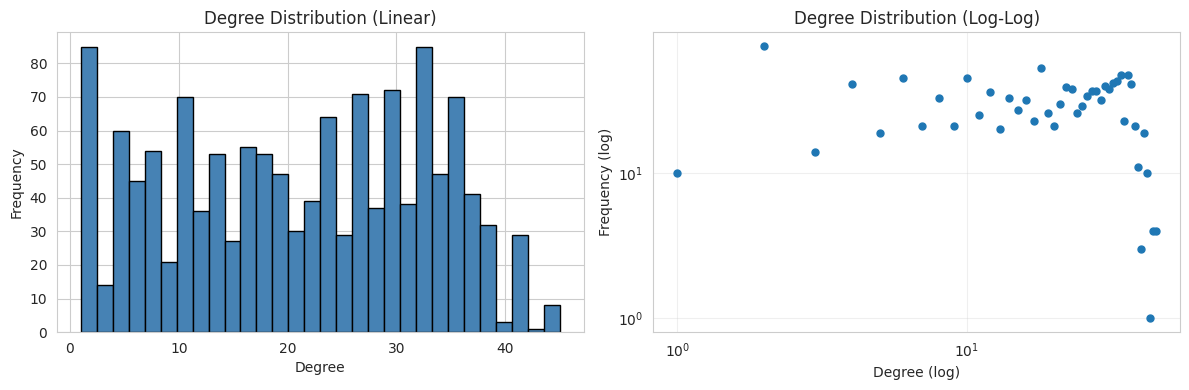

Degree Statistics:
  Min: 1
  Max: 45
  Mean: 21.00
  Median: 22


In [17]:
# --- DEGREE DISTRIBUTION: Is it Scale-Free? ---
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)

plt.figure(figsize=(12, 4))

# Linear scale
plt.subplot(1, 2, 1)
plt.hist(degree_sequence, bins=30, edgecolor='black', color='steelblue')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree Distribution (Linear)")

# Log-log scale (power law would appear as straight line)
plt.subplot(1, 2, 2)
degree_counts = pd.Series(degree_sequence).value_counts().sort_index()
plt.loglog(degree_counts.index, degree_counts.values, 'o', markersize=5)
plt.xlabel("Degree (log)")
plt.ylabel("Frequency (log)")
plt.title("Degree Distribution (Log-Log)")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Basic stats
print(f"Degree Statistics:")
print(f"  Min: {min(degree_sequence)}")
print(f"  Max: {max(degree_sequence)}")
print(f"  Mean: {sum(degree_sequence)/len(degree_sequence):.2f}")
print(f"  Median: {sorted(degree_sequence)[len(degree_sequence)//2]}")

Top Relationship Triads (The 'DNA' of the Family):
Rel_AB           Rel_BC                Rel_AC            
sisterOf         granddaughterOf       granddaughterOf       772
                 grandsonOf            granddaughterOf       722
brotherOf        granddaughterOf       grandsonOf            722
                 grandsonOf            grandsonOf            624
granddaughterOf  greatGrandfatherOf    auntOf                562
                 greatGrandmotherOf    auntOf                562
grandmotherOf    auntOf                greatGrandmotherOf    562
grandfatherOf    auntOf                greatGrandfatherOf    562
uncleOf          greatGranddaughterOf  grandsonOf            544
greatGrandsonOf  grandfatherOf         nephewOf              541
Name: count, dtype: int64


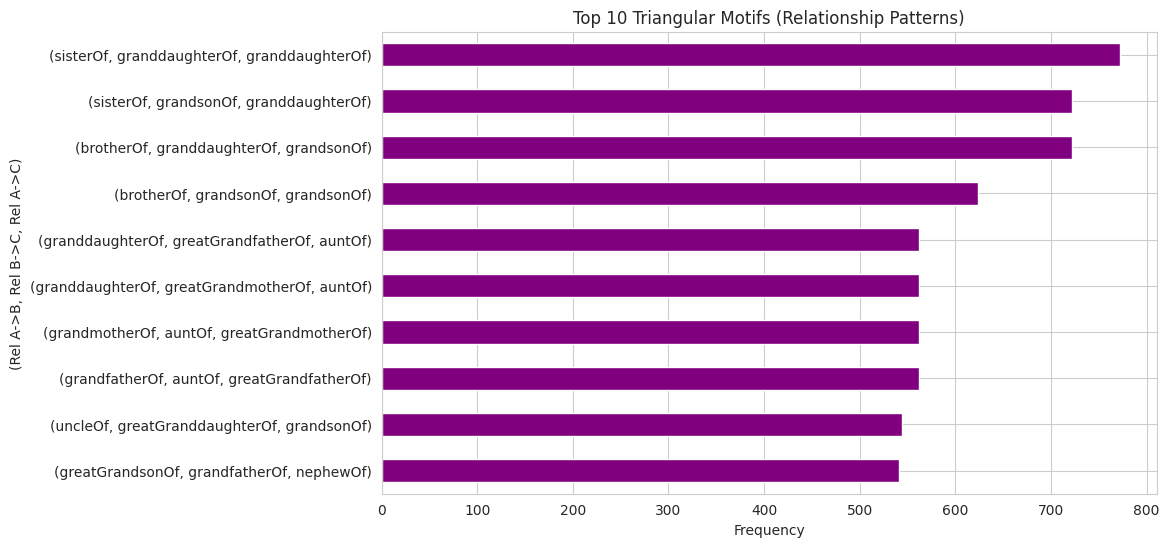


Degree Assortativity Coefficient: 0.1213
Interpretation: Positive = popular people link to popular people. Negative = hubs link to leaves.

Top 10 Most Common Names:
tobias       21
elias        20
marlene      20
florian      20
oliver       19
helena       18
sophie       18
natalie      17
lara         17
sebastian    17
Name: count, dtype: int64


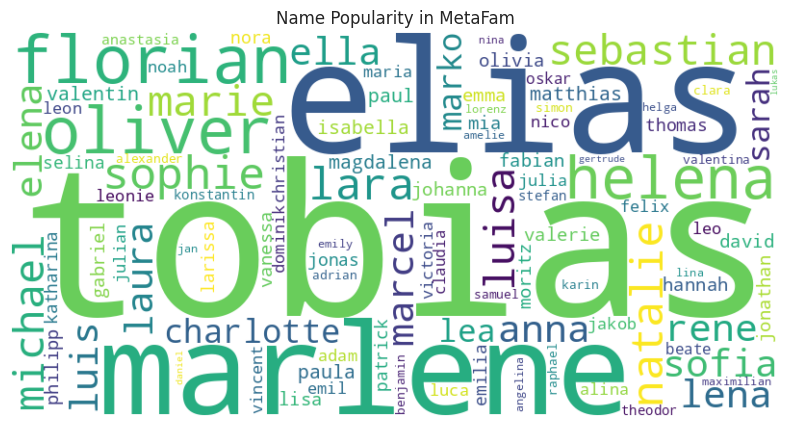

In [18]:
from itertools import combinations
import seaborn as sns

# Analyze triads: Find cases where A is related to B and B to C
triads = []
for n in G.nodes():
    neighbors = list(G.successors(n))
    if len(neighbors) < 2: continue
    for n1, n2 in combinations(neighbors, 2):
        if G.has_edge(n1, n2):
            # We found a triangle!
            r1 = G[n][n1]['relation'] # A->B
            r2 = G[n1][n2]['relation'] # B->C
            r3 = G[n][n2]['relation'] # A->C
            triads.append((r1, r2, r3))

triad_df = pd.DataFrame(triads, columns=['Rel_AB', 'Rel_BC', 'Rel_AC'])
top_motifs = triad_df.value_counts().head(10)

print("Top Relationship Triads (The 'DNA' of the Family):")
print(top_motifs)

# Visualizing Top Motifs
if not triad_df.empty:
    top_motifs.head(10).plot(kind='barh', color='purple', figsize=(10, 6))
    plt.title("Top 10 Triangular Motifs (Relationship Patterns)")
    plt.xlabel("Frequency")
    plt.ylabel("(Rel A->B, Rel B->C, Rel A->C)")
    plt.gca().invert_yaxis()
    plt.show()

# --- NEW: Assortativity Analysis ---
# Do high-degree nodes connect to high-degree nodes?
r = nx.degree_assortativity_coefficient(G)
print(f"\nDegree Assortativity Coefficient: {r:.4f}")
print("Interpretation: Positive = popular people link to popular people. Negative = hubs link to leaves.")

# --- NEW: Name Analysis ---
# Extract names from nodes (e.g. 'olivia0' -> 'olivia')
import re
names = [re.sub(r'\d+', '', node) for node in G.nodes()]
name_counts = pd.Series(names).value_counts()

print("\nTop 10 Most Common Names:")
print(name_counts.head(10))

# WordCloud
try:
    from wordcloud import WordCloud
    wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(name_counts)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title("Name Popularity in MetaFam")
    plt.show()
except ImportError:
    print("WordCloud library not found, skipping name cloud.")


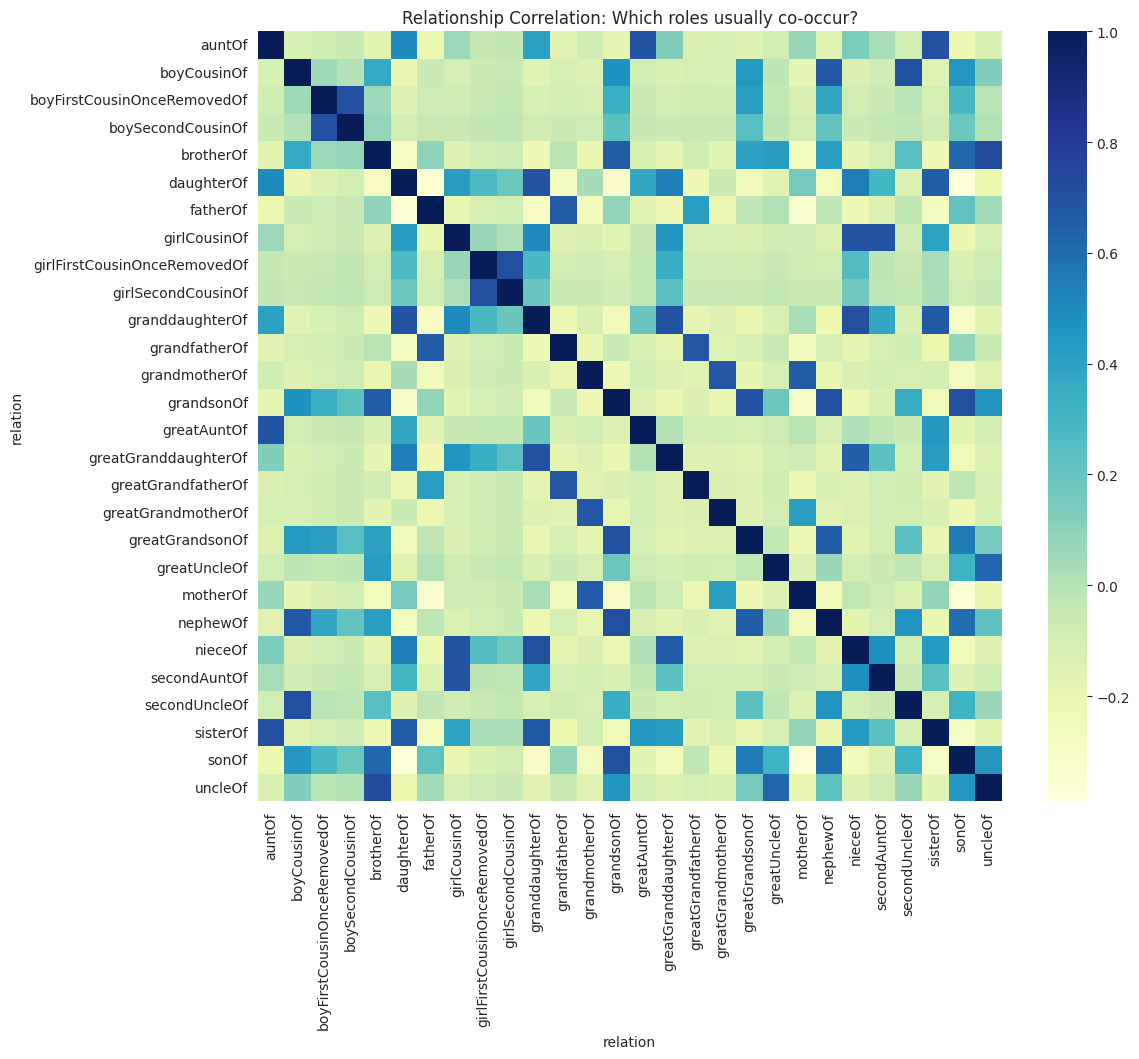

In [19]:
import seaborn as sns

# Create a pivot table of how often Relationship X connects to nodes that also have Relationship Y
# This shows 'Relationship Overlap'
adj_matrix = nx.to_pandas_adjacency(G.to_undirected())
# For a more specific KG view, analyze the frequency of Relation pairs for shared nodes
rel_counts = df.groupby(['head', 'relation']).size().unstack(fill_value=0)
rel_corr = rel_counts.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(rel_corr, annot=False, cmap='YlGnBu')
plt.title("Relationship Correlation: Which roles usually co-occur?")
plt.show()

Reciprocity Rate by Relationship Type:
--------------------------------------------------
motherOf                  |  60.6% | 289 missing of 733
fatherOf                  |  82.9% | 125 missing of 733
sonOf                     |  85.3% |  88 missing of 600
daughterOf                |  86.0% |  88 missing of 628
grandfatherOf             | 100.0% |   0 missing of 813
greatGrandmotherOf        | 100.0% |   0 missing of 617
granddaughterOf           | 100.0% |   0 missing of 812
nephewOf                  | 100.0% |   0 missing of 514
grandsonOf                | 100.0% |   0 missing of 814
greatGrandsonOf           | 100.0% |   0 missing of 624
greatGranddaughterOf      | 100.0% |   0 missing of 610
grandmotherOf             | 100.0% |   0 missing of 813
auntOf                    | 100.0% |   0 missing of 556
brotherOf                 | 100.0% |   0 missing of 570
uncleOf                   | 100.0% |   0 missing of 454
sisterOf                  | 100.0% |   0 missing of 636
nieceOf       

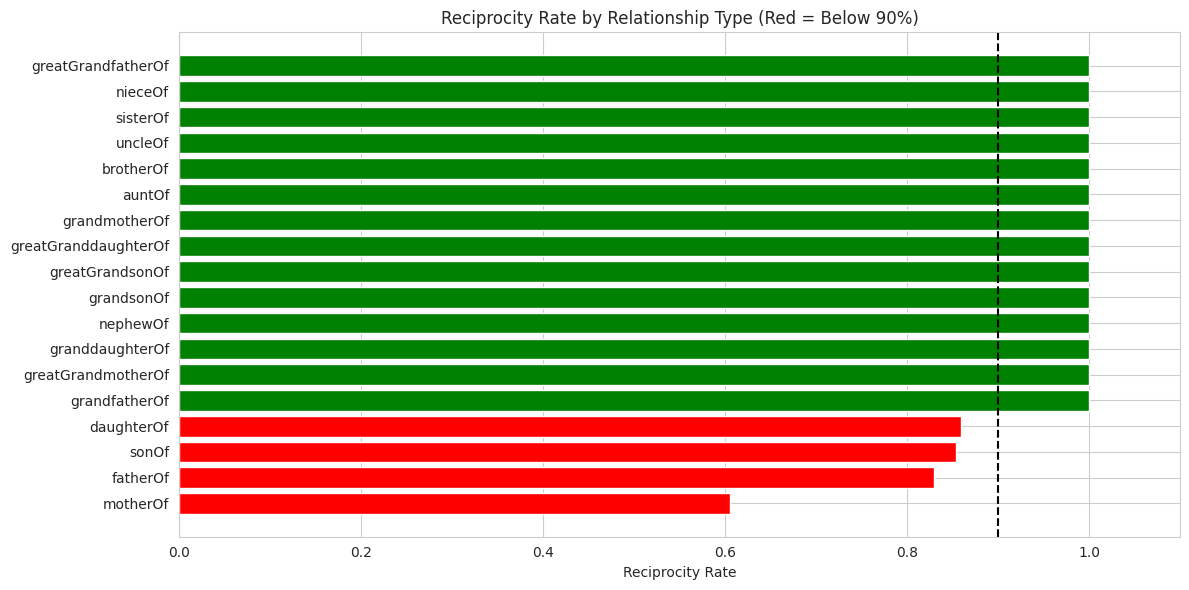

In [20]:
# --- Which relationship types have poor reciprocity? ---
from collections import defaultdict

reciprocal_map = {
    'fatherOf': ['sonOf', 'daughterOf'],
    'motherOf': ['sonOf', 'daughterOf'],
    'sonOf': ['fatherOf', 'motherOf'],
    'daughterOf': ['fatherOf', 'motherOf'],
    'brotherOf': ['brotherOf', 'sisterOf'],
    'sisterOf': ['brotherOf', 'sisterOf'],
    'grandfatherOf': ['grandsonOf', 'granddaughterOf'],
    'grandmotherOf': ['grandsonOf', 'granddaughterOf'],
    'grandsonOf': ['grandfatherOf', 'grandmotherOf'],
    'granddaughterOf': ['grandfatherOf', 'grandmotherOf'],
    'uncleOf': ['nephewOf', 'nieceOf'],
    'auntOf': ['nephewOf', 'nieceOf'],
    'nephewOf': ['uncleOf', 'auntOf'],
    'nieceOf': ['uncleOf', 'auntOf'],
    'greatGrandfatherOf': ['greatGrandsonOf', 'greatGranddaughterOf'],
    'greatGrandmotherOf': ['greatGrandsonOf', 'greatGranddaughterOf'],
    'greatGrandsonOf': ['greatGrandfatherOf', 'greatGrandmotherOf'],
    'greatGranddaughterOf': ['greatGrandfatherOf', 'greatGrandmotherOf'],
}

edge_set = set(zip(df['head'], df['relation'], df['tail']))
reciprocity_by_relation = defaultdict(lambda: {'total': 0, 'found': 0})

for h, r, t in edge_set:
    if r in reciprocal_map:
        reciprocity_by_relation[r]['total'] += 1
        expected_relations = reciprocal_map[r]
        found = any((t, exp_r, h) in edge_set for exp_r in expected_relations)
        if found:
            reciprocity_by_relation[r]['found'] += 1

print("Reciprocity Rate by Relationship Type:")
print("-" * 50)
recip_data = []
for rel, counts in sorted(reciprocity_by_relation.items(), key=lambda x: x[1]['found']/max(x[1]['total'],1)):
    rate = counts['found'] / counts['total'] if counts['total'] > 0 else 0
    missing = counts['total'] - counts['found']
    print(f"{rel:25} | {rate*100:5.1f}% | {missing:3} missing of {counts['total']}")
    recip_data.append({'relation': rel, 'rate': rate, 'missing': missing, 'total': counts['total']})

recip_df = pd.DataFrame(recip_data)

# Visualize
plt.figure(figsize=(12, 6))
colors = ['red' if r < 0.9 else 'green' for r in recip_df['rate']]
plt.barh(recip_df['relation'], recip_df['rate'], color=colors)
plt.xlabel('Reciprocity Rate')
plt.title('Reciprocity Rate by Relationship Type (Red = Below 90%)')
plt.axvline(x=0.9, color='black', linestyle='--', label='90% threshold')
plt.xlim(0, 1.1)
plt.tight_layout()
plt.show()

Analyzing structural isomorphism of families...

Structural Analysis Results:
Total Families: 50
Unique Structures (Isomorphism Classes): 50
INSIGHT: Every family is unique in structure.

Family Structure Summary Statistics:
         size   edges  num_generations  max_generation  density
count  50.000   50.00           50.000          50.000   50.000
mean   26.320  276.42            5.580           4.580    0.415
std     0.471   51.51            0.785           0.785    0.077
min    26.000  179.00            4.000           3.000    0.275
25%    26.000  243.25            5.000           4.000    0.351
50%    26.000  276.50            6.000           5.000    0.416
75%    27.000  303.00            6.000           5.000    0.460
max    27.000  412.00            7.000           6.000    0.587


/usr/local/lib/python3.12/dist-packages/networkx/algorithms/graph_hashing.py:211: UserWarning: The hashes produced for graphs without node or edge attributeschanged in v3.5 due to a bugfix (see documentation).
  node_labels = _init_node_labels(G, edge_attr, node_attr)


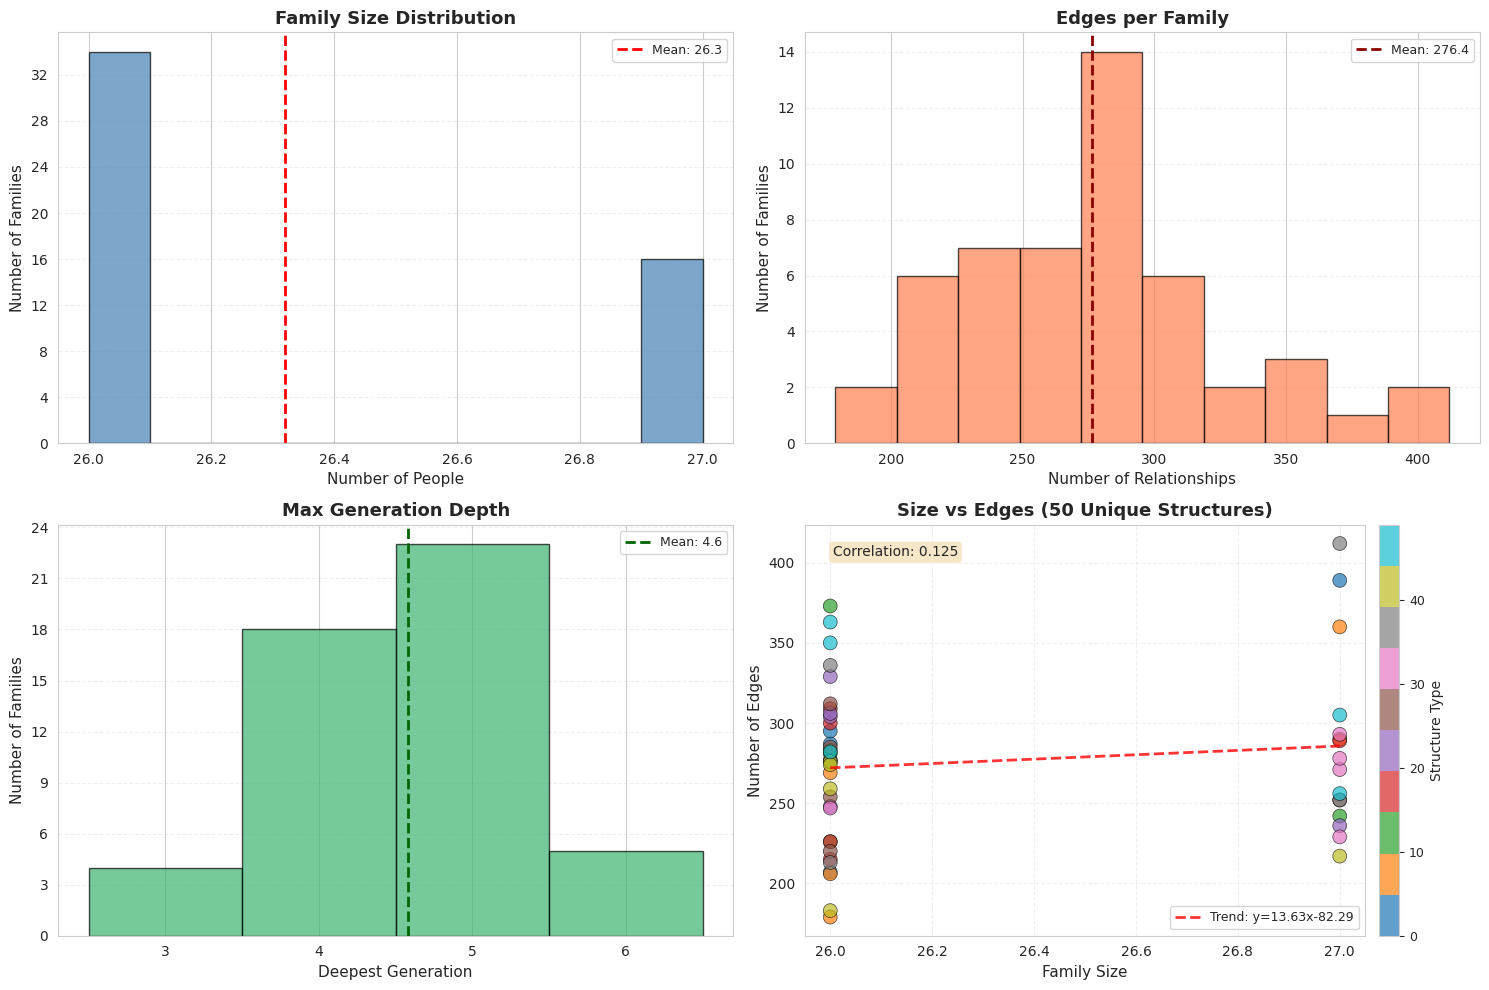

In [46]:
# --- Are all 50 families structurally identical? ---
import numpy as np
from networkx.algorithms.graph_hashing import weisfeiler_lehman_graph_hash
family_stats = []
wl_hashes = []
print("Analyzing structural isomorphism of families...")
for i, component in enumerate(nx.weakly_connected_components(G)):
    subgraph = G.subgraph(component)
    
    # 1. Basic Stats
    # Get generations for this family
    family_gens = {n: generations.get(n, -1) for n in component}
    gen_counts = pd.Series(family_gens.values()).value_counts().sort_index()
    
    # 2. Advanced: Weisfeiler-Lehman Hash
    # This hash is identical if and only if two graphs are isomorphic (structurally same)
    # We use the undirected version for structural comparison
    struct_hash = weisfeiler_lehman_graph_hash(subgraph.to_undirected())
    wl_hashes.append(struct_hash)
    stats = {
        'family_id': i,
        'size': len(component),
        'edges': subgraph.number_of_edges(),
        'density': nx.density(subgraph),
        'num_generations': len([g for g in gen_counts.index if g >= 0]),
        'max_generation': max(family_gens.values()),
        'avg_degree': sum(dict(subgraph.degree()).values()) / len(component),
        'structure_hash': struct_hash
    }
    family_stats.append(stats)
family_df = pd.DataFrame(family_stats)

# Count unique structures
unique_structures = family_df['structure_hash'].nunique()
print(f"\nStructural Analysis Results:")
print(f"Total Families: {len(family_df)}")
print(f"Unique Structures (Isomorphism Classes): {unique_structures}")
if unique_structures == 1:
    print("INSIGHT: All 50 families are perfectly isomorphic (identical structures)!")
elif unique_structures == len(family_df):
    print("INSIGHT: Every family is unique in structure.")
else:
    print(f"INSIGHT: There are {unique_structures} distinct family templates among {len(family_df)} families.")
    print("Most common structure count:", family_df['structure_hash'].value_counts().max())

print("\nFamily Structure Summary Statistics:")
print(family_df[['size', 'edges', 'num_generations', 'max_generation', 'density']].describe().round(3))

# Visualize family comparison with improvements
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Family Size Distribution
axes[0,0].hist(family_df['size'], bins=10, edgecolor='black', color='steelblue', alpha=0.7)
axes[0,0].set_title('Family Size Distribution', fontsize=13, fontweight='bold')
axes[0,0].set_xlabel('Number of People', fontsize=11)
axes[0,0].set_ylabel('Number of Families', fontsize=11)
axes[0,0].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0,0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0,0].axvline(family_df['size'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f"Mean: {family_df['size'].mean():.1f}")
axes[0,0].legend(fontsize=9)

# Edges per Family
axes[0,1].hist(family_df['edges'], bins=10, edgecolor='black', color='coral', alpha=0.7)
axes[0,1].set_title('Edges per Family', fontsize=13, fontweight='bold')
axes[0,1].set_xlabel('Number of Relationships', fontsize=11)
axes[0,1].set_ylabel('Number of Families', fontsize=11)
axes[0,1].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[0,1].grid(axis='y', alpha=0.3, linestyle='--')
axes[0,1].axvline(family_df['edges'].mean(), color='darkred', linestyle='--', linewidth=2, 
                label=f"Mean: {family_df['edges'].mean():.1f}")
axes[0,1].legend(fontsize=9)

# Max Generation Depth
axes[1,0].hist(family_df['max_generation'], 
               bins=range(int(family_df['max_generation'].min()), int(family_df['max_generation'].max())+2), 
               edgecolor='black', color='mediumseagreen', alpha=0.7, align='left')
axes[1,0].set_title('Max Generation Depth', fontsize=13, fontweight='bold')
axes[1,0].set_xlabel('Deepest Generation', fontsize=11)
axes[1,0].set_ylabel('Number of Families', fontsize=11)
axes[1,0].set_xticks(range(int(family_df['max_generation'].min()), int(family_df['max_generation'].max())+1))
axes[1,0].yaxis.set_major_locator(plt.MaxNLocator(integer=True))
axes[1,0].grid(axis='y', alpha=0.3, linestyle='--')
axes[1,0].axvline(family_df['max_generation'].mean(), color='darkgreen', linestyle='--', linewidth=2, 
                  label=f"Mean: {family_df['max_generation'].mean():.1f}")
axes[1,0].legend(fontsize=9)

# Size vs Edges (Color by Structure)
structure_colors = pd.factorize(family_df['structure_hash'])[0]
scatter = axes[1,1].scatter(family_df['size'], family_df['edges'], 
                         alpha=0.7, s=100, 
                         c=structure_colors, cmap='tab10',
                         edgecolors='black', linewidth=0.5)
axes[1,1].set_title(f'Size vs Edges ({unique_structures} Unique Structure{"s" if unique_structures > 1 else ""})', 
                  fontsize=13, fontweight='bold')
axes[1,1].set_xlabel('Family Size', fontsize=11)
axes[1,1].set_ylabel('Number of Edges', fontsize=11)
axes[1,1].grid(alpha=0.3, linestyle='--')

# Add trend line
z = np.polyfit(family_df['size'], family_df['edges'], 1)
p = np.poly1d(z)
x_trend = np.linspace(family_df['size'].min(), family_df['size'].max(), 100)
axes[1,1].plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, 
             label=f'Trend: y={z[0]:.2f}x{z[1]:+.2f}')

# Add correlation coefficient
corr = family_df['size'].corr(family_df['edges'])
axes[1,1].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
             transform=axes[1,1].transAxes, fontsize=10, 
             verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))

# Add colorbar if multiple structures exist
if unique_structures > 1:
    cbar = plt.colorbar(scatter, ax=axes[1,1], pad=0.02)
    cbar.set_label('Structure Type', fontsize=10)
    cbar.ax.tick_params(labelsize=9)

axes[1,1].legend(fontsize=9, loc='lower right')

plt.tight_layout()
plt.show()

Detected 445 unique couples (parent pairs)

Children per couple:
  Min: 1
  Max: 5
  Mean: 1.84


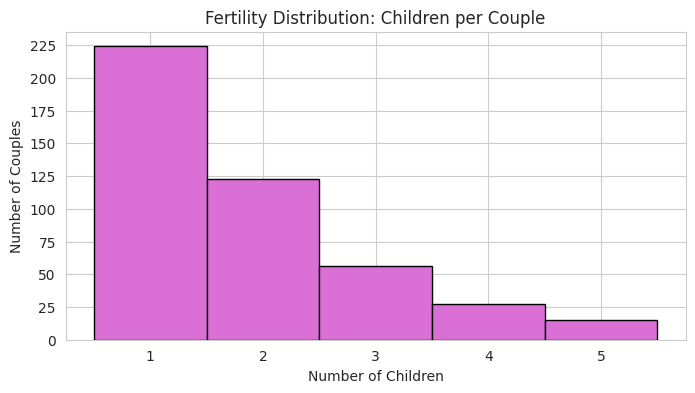


Example couples and their children:
  dominik2 + katharina1 → {'oskar24', 'olivia0', 'adam9', 'isabella11', 'selina10'}
  oliver3 + olivia0 → {'lisa5', 'nico4', 'elias6'}
  emma7 + moritz8 → {'paula12', 'natalie13', 'katharina1', 'luis14'}
  paula12 + vincent21 → {'jonas23', 'johanna22'}
  emily15 + luis14 → {'leon16'}


In [42]:
# --- MARRIAGE DETECTION: Who had children together? ---
from collections import defaultdict
# Find all parent pairs for each child
child_to_parents = defaultdict(set)
for h, r, t in zip(df['head'], df['relation'], df['tail']):
    if r in ['fatherOf', 'motherOf']:
        child_to_parents[t].add(h)
    elif r in ['sonOf', 'daughterOf']:
        child_to_parents[h].add(t)
# Extract couples (parent pairs)
couples = set()
for child, parents in child_to_parents.items():
    if len(parents) == 2:
        couple = tuple(sorted(parents))
        couples.add(couple)
print(f"Detected {len(couples)} unique couples (parent pairs)")
# Analyze couple fertility (number of children per couple)
couple_children = defaultdict(set)
for child, parents in child_to_parents.items():
    if len(parents) == 2:
        couple = tuple(sorted(parents))
        couple_children[couple].add(child)
children_counts = [len(kids) for kids in couple_children.values()]
print(f"\nChildren per couple:")
print(f"  Min: {min(children_counts)}")
print(f"  Max: {max(children_counts)}")
print(f"  Mean: {sum(children_counts)/len(children_counts):.2f}")
plt.figure(figsize=(8, 4))
plt.hist(children_counts, bins=range(1, max(children_counts)+2), edgecolor='black', color='orchid', align='left')
plt.xlabel('Number of Children')
plt.ylabel('Number of Couples')
plt.title('Fertility Distribution: Children per Couple')
plt.xticks(range(1, max(children_counts)+1))
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()
# Show a few example couples
print("\nExample couples and their children:")
for couple, children in list(couple_children.items())[:5]:
    print(f"  {couple[0]} + {couple[1]} → {children}")

In [23]:
# --- CRITICAL: Are missing reciprocals in test.txt? ---
# Load test set
try:
    test_file_path = '/kaggle/input/test-txt/test.txt'
    test_df = pd.read_csv(test_file_path, sep='\s+', names=['head', 'relation', 'tail'])
except:
    test_file_path = '../The Problem/test.txt'
    test_df = pd.read_csv(test_file_path, sep='\s+', names=['head', 'relation', 'tail'])

print(f"Test set size: {len(test_df)} triples")

test_edge_set = set(zip(test_df['head'], test_df['relation'], test_df['tail']))

# Check our missing reciprocals
missing_in_test = 0
missing_not_in_test = 0
missing_reciprocals_detailed = []

for h, r, t in edge_set:
    if r in reciprocal_map:
        expected_relations = reciprocal_map[r]
        found_in_train = any((t, exp_r, h) in edge_set for exp_r in expected_relations)
        if not found_in_train:
            # Check if it's in test
            found_in_test = any((t, exp_r, h) in test_edge_set for exp_r in expected_relations)
            if found_in_test:
                missing_in_test += 1
            else:
                missing_not_in_test += 1
                missing_reciprocals_detailed.append((h, r, t))

print(f"\nMissing reciprocals found in TEST set: {missing_in_test}")
print(f"Missing reciprocals NOT in test set: {missing_not_in_test}")

if missing_in_test > 0:
    print(f"\nMAJOR INSIGHT: {missing_in_test} of the missing reciprocal edges are hidden in the test set.")
    print("   This clearly indicates the Link Prediction task (Task 4) is partially about restoring reciprocity.")
    print("   Strategy for Task 4: Simple rule-based reciprocals could score very high link prediction accuracy.")


Test set size: 590 triples

Missing reciprocals found in TEST set: 590
Missing reciprocals NOT in test set: 0

MAJOR INSIGHT: 590 of the missing reciprocal edges are hidden in the test set.
   This clearly indicates the Link Prediction task (Task 4) is partially about restoring reciprocity.
   Strategy for Task 4: Simple rule-based reciprocals could score very high link prediction accuracy.


<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_55/1160507130.py:5: SyntaxWarning: invalid escape sequence '\s'
  test_df = pd.read_csv(test_file_path, sep='\s+', names=['head', 'relation', 'tail'])
/tmp/ipykernel_55/1160507130.py:8: SyntaxWarning: invalid escape sequence '\s'
  test_df = pd.read_csv(test_file_path, sep='\s+', names=['head', 'relation', 'tail'])


Top 10 by DESCENDANTS (Progenitors):
               descendants  generation
node                                  
emma7                   17           0
moritz8                 17           0
marie113                17           0
daniel114               17           0
sofia191                17           0
michael192              17           0
christian1226           17           0
natalie1225             17           0
larissa1275             17           0
christian1276           17           0

Top 10 by ANCESTORS (Youngest with most recorded lineage):
             ancestors  generation
node                              
elena257            20           6
valerie260          20           6
sarah251            20           6
hannah39            18           5
dominik44           18           5
marko180            18           6
benjamin247         18           5
david832            18           5
jakob835            18           5
elena822            18           5

Top 10 by LINE

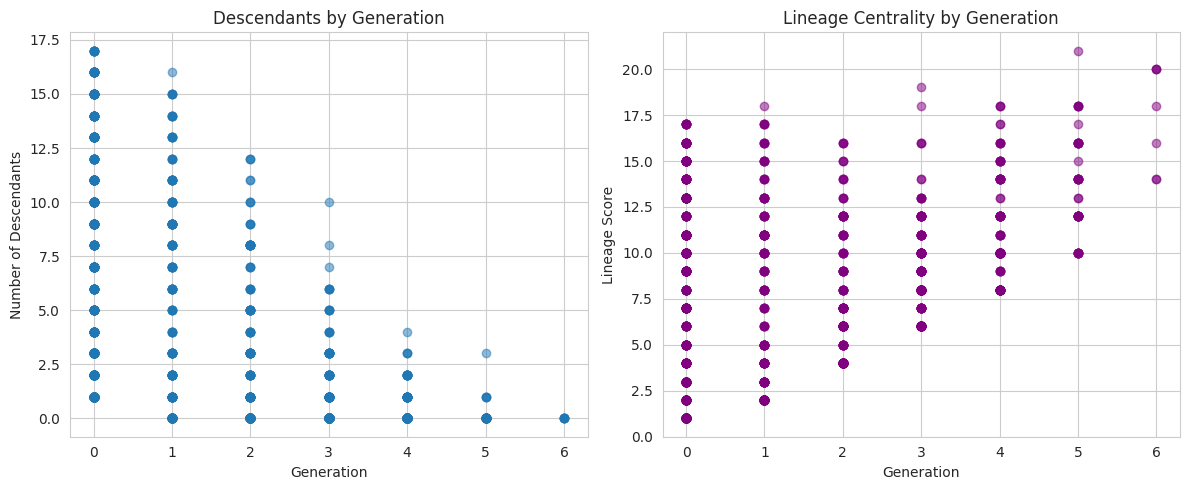

In [24]:
# --- FAMILY-SPECIFIC IMPORTANCE METRICS ---

# 1. PROGENITOR SCORE: How many descendants does each person have?
descendants_count = {}
for node in G.nodes():
    if node in time_graph:
        descendants = nx.descendants(time_graph, node)
        descendants_count[node] = len(descendants)
    else:
        descendants_count[node] = 0

# 2. ANCESTOR SCORE: How many ancestors does each person have?
ancestors_count = {}
for node in G.nodes():
    if node in time_graph:
        ancestors = nx.ancestors(time_graph, node)
        ancestors_count[node] = len(ancestors)
    else:
        ancestors_count[node] = 0

# 3. LINEAGE CENTRALITY: descendants + ancestors (spans most generations)
lineage_score = {n: descendants_count.get(n, 0) + ancestors_count.get(n, 0) for n in G.nodes()}

# Create importance dataframe
importance_df = pd.DataFrame({
    'node': list(G.nodes()),
    'degree': [G.degree(n) for n in G.nodes()],
    'descendants': [descendants_count.get(n, 0) for n in G.nodes()],
    'ancestors': [ancestors_count.get(n, 0) for n in G.nodes()],
    'lineage_score': [lineage_score.get(n, 0) for n in G.nodes()],
    'generation': [generations.get(n, -1) for n in G.nodes()],
}).set_index('node')

print("Top 10 by DESCENDANTS (Progenitors):")
print(importance_df.nlargest(10, 'descendants')[['descendants', 'generation']])

print("\nTop 10 by ANCESTORS (Youngest with most recorded lineage):")
print(importance_df.nlargest(10, 'ancestors')[['ancestors', 'generation']])

print("\nTop 10 by LINEAGE SCORE (Most central in time):")
print(importance_df.nlargest(10, 'lineage_score')[['lineage_score', 'generation', 'descendants', 'ancestors']])

# Visualize: Generation vs Importance
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(importance_df['generation'], importance_df['descendants'], alpha=0.5)
plt.xlabel('Generation')
plt.ylabel('Number of Descendants')
plt.title('Descendants by Generation')

plt.subplot(1, 2, 2)
plt.scatter(importance_df['generation'], importance_df['lineage_score'], alpha=0.5, color='purple')
plt.xlabel('Generation')
plt.ylabel('Lineage Score')
plt.title('Lineage Centrality by Generation')
plt.tight_layout()
plt.show()

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_55/988524005.py:2: SyntaxWarning: invalid escape sequence '\s'
  test_df = pd.read_csv('/kaggle/input/test-txt/test.txt', sep='\s+', names=['head', 'relation', 'tail'])


Test Set Composition:
Total edges: 590

Relationship distribution in TEST set:
relation
sonOf         214
daughterOf    200
fatherOf       88
motherOf       88
Name: count, dtype: int64


Train vs Test Distribution:
                              train  test  train_pct  test_pct  ratio
relation                                                             
sonOf                           600   214        4.3      36.3   0.36
daughterOf                      628   200        4.5      33.9   0.32
motherOf                        733    88        5.3      14.9   0.12
fatherOf                        733    88        5.3      14.9   0.12
boySecondCousinOf                68     0        0.5       0.0   0.00
boyFirstCousinOnceRemovedOf     180     0        1.3       0.0   0.00
brotherOf                       570     0        4.1       0.0   0.00
girlCousinOf                    445     0        3.2       0.0   0.00
girlFirstCousinOnceRemovedOf    153     0        1.1       0.0   0.00
girlSecondCous

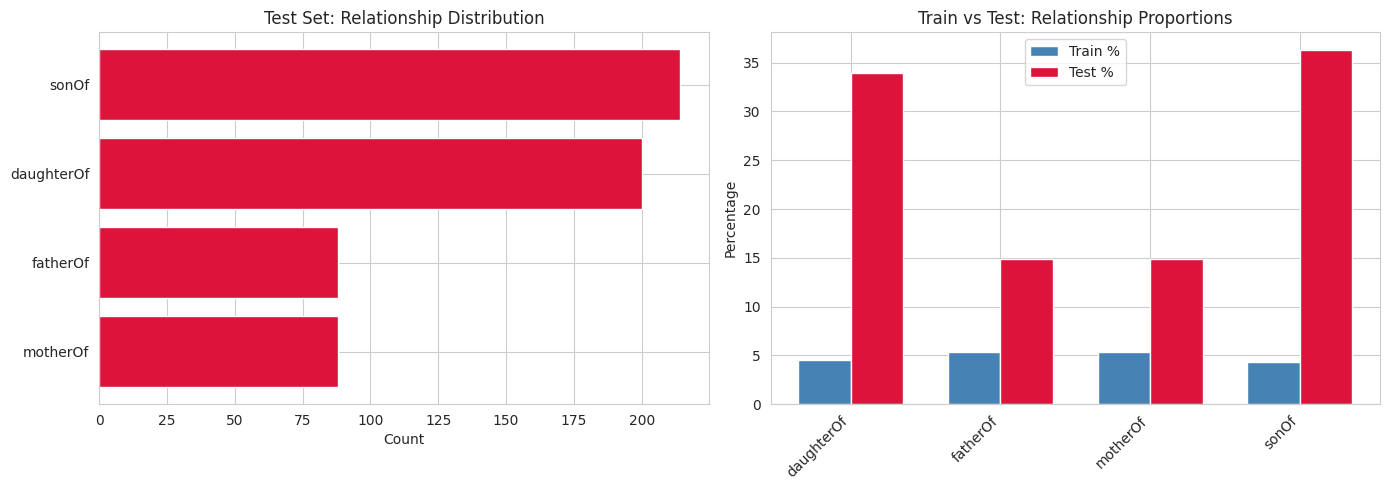

In [25]:
# --- Just exploring: What exactly is in the test set? ---
test_df = pd.read_csv('/kaggle/input/test-txt/test.txt', sep='\s+', names=['head', 'relation', 'tail'])

print("Test Set Composition:")
print(f"Total edges: {len(test_df)}")
print("\nRelationship distribution in TEST set:")
test_rel_counts = test_df['relation'].value_counts()
print(test_rel_counts)

# Compare to train distribution
train_rel_counts = df['relation'].value_counts()

# Create comparison dataframe
comparison = pd.DataFrame({
    'train': train_rel_counts,
    'test': test_rel_counts
}).fillna(0).astype(int)
comparison['train_pct'] = (comparison['train'] / comparison['train'].sum() * 100).round(1)
comparison['test_pct'] = (comparison['test'] / comparison['test'].sum() * 100).round(1)
comparison['ratio'] = (comparison['test'] / comparison['train'].replace(0, 1)).round(2)

print("\n\nTrain vs Test Distribution:")
print(comparison.sort_values('test', ascending=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
print("Number of relations in test:", len(test_rel_counts))

# Test set composition
axes[0].barh(test_rel_counts.index, test_rel_counts.values, color='crimson')
axes[0].set_xlabel('Count')
axes[0].set_title('Test Set: Relationship Distribution')
axes[0].invert_yaxis()

# Comparison
relations_in_test = comparison[comparison['test'] > 0].index.tolist()
x = range(len(relations_in_test))
width = 0.35
axes[1].bar([i - width/2 for i in x], comparison.loc[relations_in_test, 'train_pct'], 
            width, label='Train %', color='steelblue')
axes[1].bar([i + width/2 for i in x], comparison.loc[relations_in_test, 'test_pct'], 
            width, label='Test %', color='crimson')
axes[1].set_xticks(x)
axes[1].set_xticklabels(relations_in_test, rotation=45, ha='right')
axes[1].set_ylabel('Percentage')
axes[1].set_title('Train vs Test: Relationship Proportions')
axes[1].legend()

plt.tight_layout()
plt.show()

Correlation: Max Generation vs Edge Count
  Pearson correlation: -0.425

Correlation: Max Generation vs Great-Grandparent Edges
  Pearson correlation: 0.251


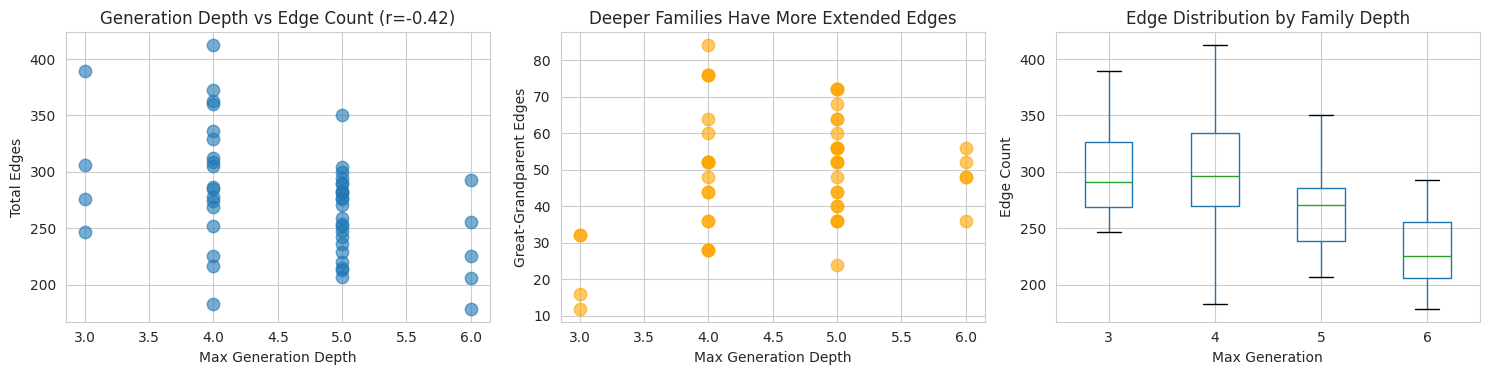

In [26]:
# --- Why do edge counts vary across families? ---
# Hypothesis: More generations = more extended family edges

# Recalculate with more detail
family_detailed = []

for i, component in enumerate(nx.weakly_connected_components(G)):
    subgraph = G.subgraph(component)
    
    # Count relationship types in this family
    family_edges = df[(df['head'].isin(component)) | (df['tail'].isin(component))]
    
    # Get generation stats
    family_gens = [generations.get(n, 0) for n in component]
    
    stats = {
        'family_id': i,
        'size': len(component),
        'edges': subgraph.number_of_edges(),
        'max_generation': max(family_gens),
        'num_grandparent_edges': len(family_edges[family_edges['relation'].isin(['grandfatherOf', 'grandmotherOf', 'grandsonOf', 'granddaughterOf'])]),
        'num_greatgrandparent_edges': len(family_edges[family_edges['relation'].isin(['greatGrandfatherOf', 'greatGrandmotherOf', 'greatGrandsonOf', 'greatGranddaughterOf'])]),
        'num_cousin_edges': len(family_edges[family_edges['relation'].str.contains('Cousin', case=False)]),
    }
    family_detailed.append(stats)

family_detail_df = pd.DataFrame(family_detailed)

# Correlation analysis
print("Correlation: Max Generation vs Edge Count")
corr = family_detail_df['max_generation'].corr(family_detail_df['edges'])
print(f"  Pearson correlation: {corr:.3f}")

print("\nCorrelation: Max Generation vs Great-Grandparent Edges")
corr2 = family_detail_df['max_generation'].corr(family_detail_df['num_greatgrandparent_edges'])
print(f"  Pearson correlation: {corr2:.3f}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(family_detail_df['max_generation'], family_detail_df['edges'], alpha=0.6, s=80)
axes[0].set_xlabel('Max Generation Depth')
axes[0].set_ylabel('Total Edges')
axes[0].set_title(f'Generation Depth vs Edge Count (r={corr:.2f})')

axes[1].scatter(family_detail_df['max_generation'], family_detail_df['num_greatgrandparent_edges'], 
                alpha=0.6, s=80, color='orange')
axes[1].set_xlabel('Max Generation Depth')
axes[1].set_ylabel('Great-Grandparent Edges')
axes[1].set_title('Deeper Families Have More Extended Edges')

# Box plot of edges by generation
family_detail_df.boxplot(column='edges', by='max_generation', ax=axes[2])
axes[2].set_xlabel('Max Generation')
axes[2].set_ylabel('Edge Count')
axes[2].set_title('Edge Distribution by Family Depth')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()

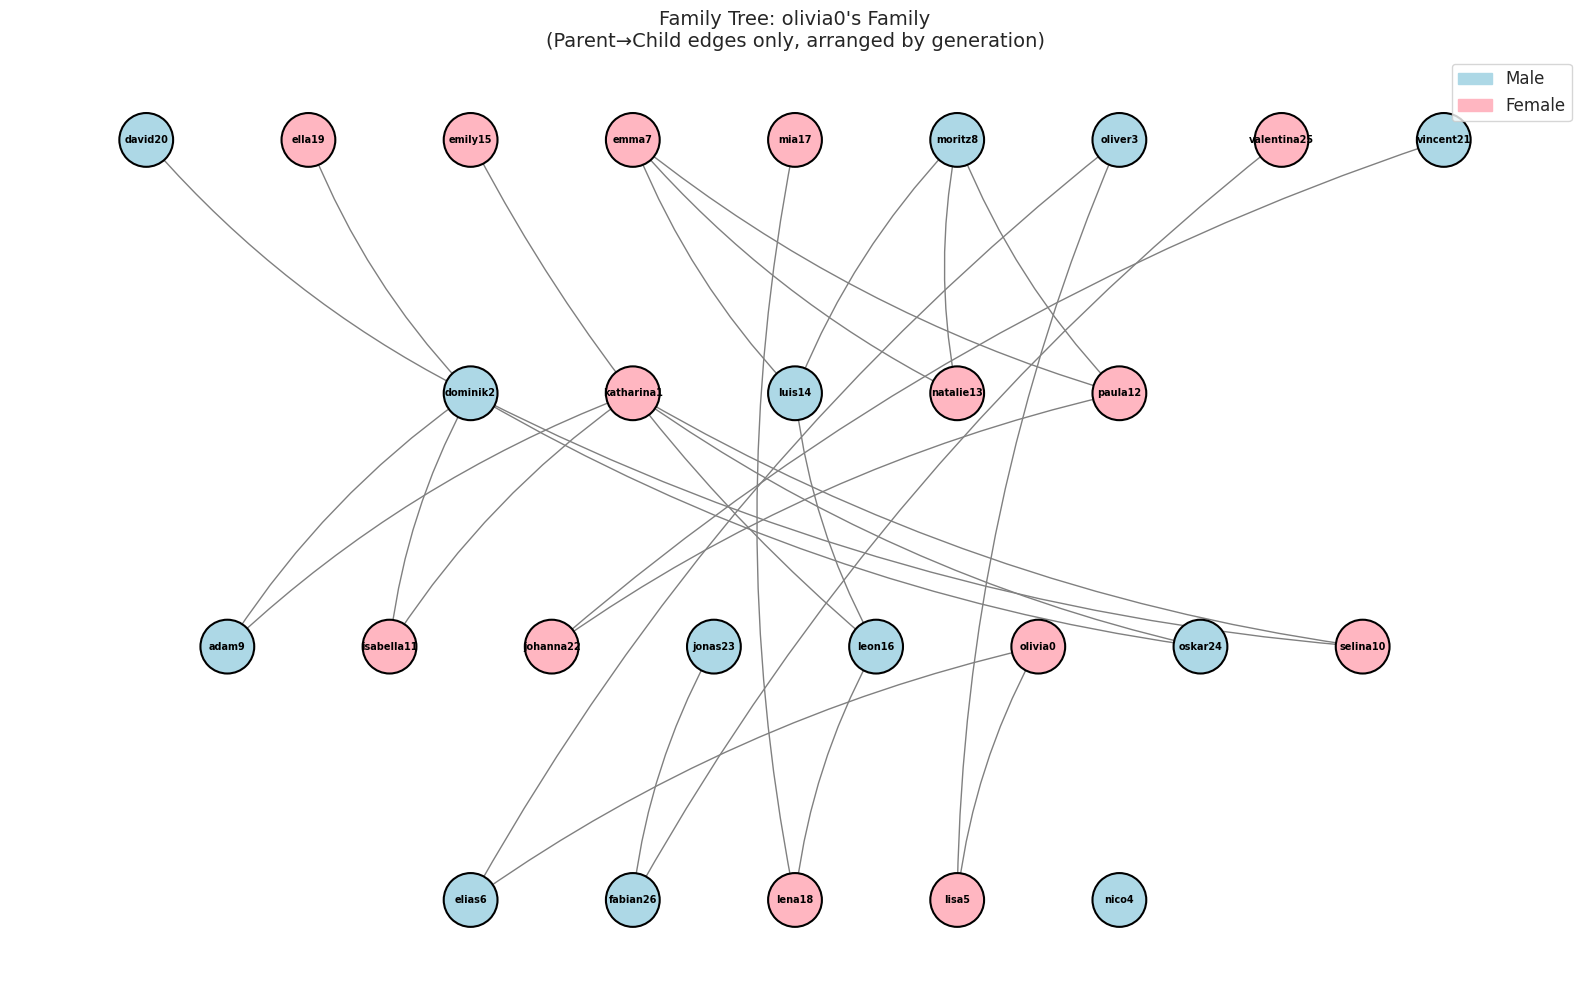


Family contains 27 members across 4 generations
Generation sizes: [(0, 9), (1, 5), (2, 8), (3, 5)]


In [27]:
# --- VISUALIZATION: Hierarchical Family Tree ---
import matplotlib.patches as mpatches

# Pick the first family (component with olivia0)
target_node = 'olivia0'
for component in nx.weakly_connected_components(G):
    if target_node in component:
        family_nodes = component
        break

family_subgraph = G.subgraph(family_nodes).copy()

# Create hierarchy layout based on generations
pos = {}
gen_counts = {}

# Count nodes per generation for positioning
for node in family_nodes:
    gen = generations.get(node, 0)
    if gen not in gen_counts:
        gen_counts[gen] = []
    gen_counts[gen].append(node)

# Position nodes
for gen, nodes in gen_counts.items():
    for i, node in enumerate(sorted(nodes)):
        # x = horizontal spread within generation
        # y = generation (inverted so ancestors at top)
        x = (i - len(nodes)/2) * 2
        y = -gen  # Negative so gen 0 is at top
        pos[node] = (x, y)

# Color by gender
node_colors = []
for node in family_subgraph.nodes():
    gender = inferred_gender.get(node, 'Unknown')
    if gender == 'M':
        node_colors.append('lightblue')
    elif gender == 'F':
        node_colors.append('lightpink')
    else:
        node_colors.append('lightgray')

# Only draw parent-child edges for clarity
parent_child_edges = [(u, v) for u, v, d in family_subgraph.edges(data=True) 
                       if d['relation'] in ['fatherOf', 'motherOf']]

plt.figure(figsize=(16, 10))

# Draw the tree
nx.draw_networkx_nodes(family_subgraph, pos, node_color=node_colors, 
                       node_size=1500, edgecolors='black', linewidths=1.5)
nx.draw_networkx_labels(family_subgraph, pos, font_size=7, font_weight='bold')
nx.draw_networkx_edges(family_subgraph, pos, edgelist=parent_child_edges,
                       edge_color='gray', arrows=True, arrowsize=15, 
                       connectionstyle="arc3,rad=0.1")

# Legend
blue_patch = mpatches.Patch(color='lightblue', label='Male')
pink_patch = mpatches.Patch(color='lightpink', label='Female')
plt.legend(handles=[blue_patch, pink_patch], loc='upper right', fontsize=12)

plt.title(f"Family Tree: {target_node}'s Family\n(Parent→Child edges only, arranged by generation)", 
          fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\nFamily contains {len(family_nodes)} members across {len(gen_counts)} generations")
print(f"Generation sizes: {[(gen, len(nodes)) for gen, nodes in sorted(gen_counts.items())]}")

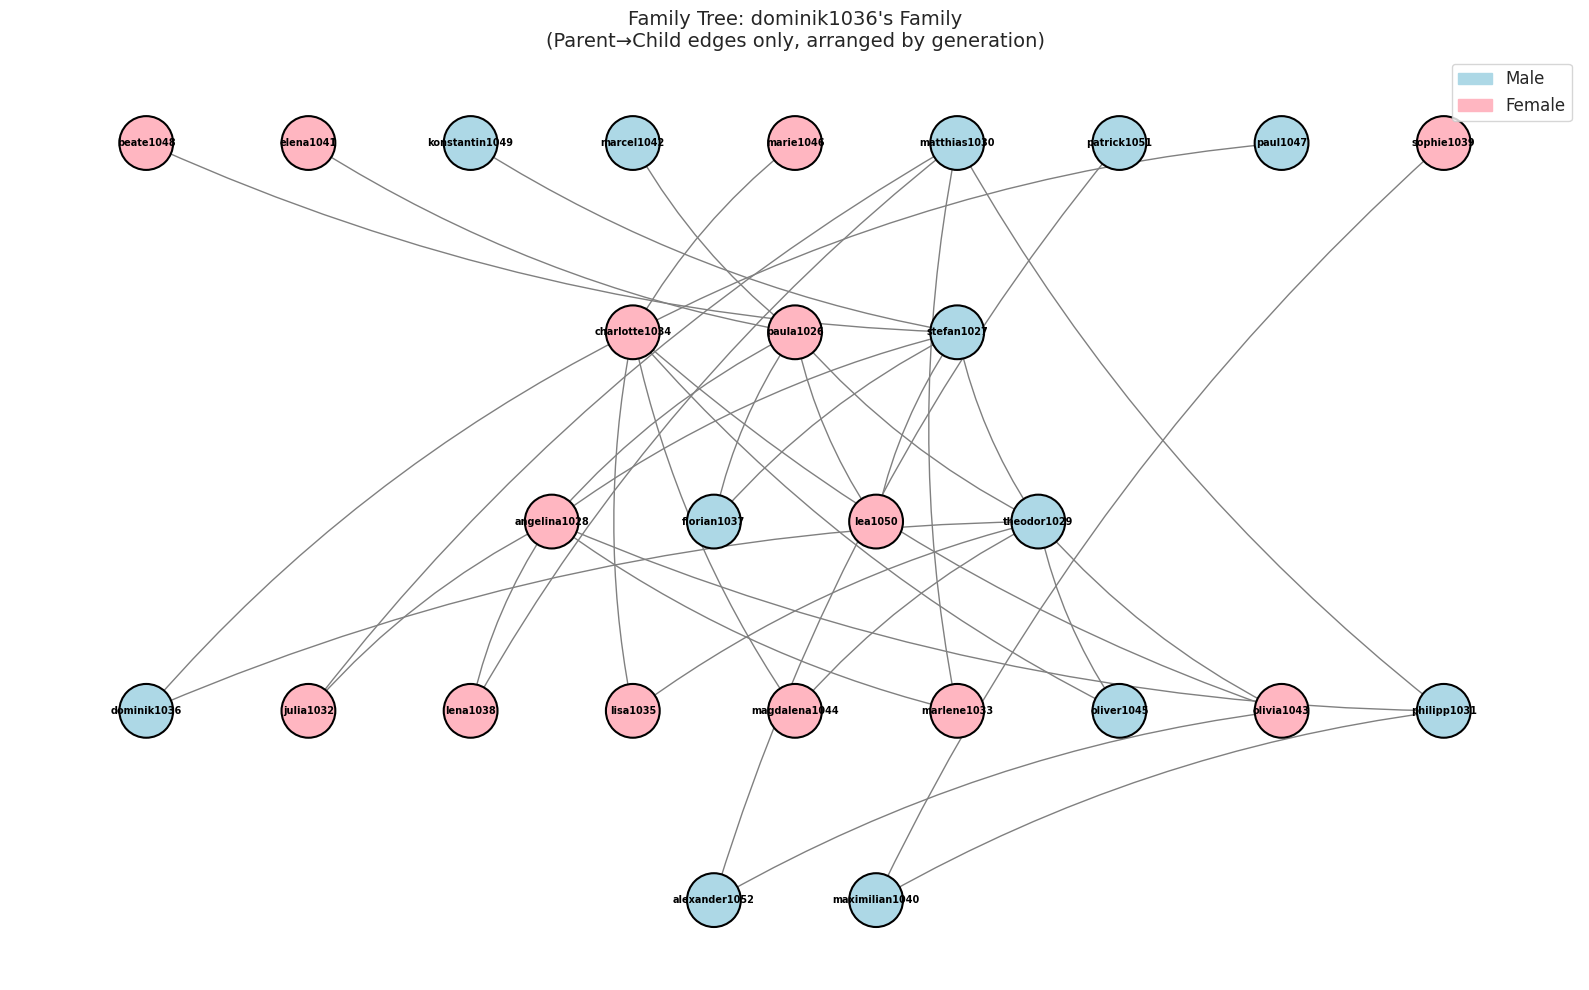


Family contains 27 members across 5 generations
Generation sizes: [(0, 9), (1, 3), (2, 4), (3, 9), (4, 2)]


In [51]:
# --- VISUALIZATION: Hierarchical Family Tree ---
import matplotlib.patches as mpatches

# Dominik's family(the man with the most connections)
target_node = 'dominik1036'
for component in nx.weakly_connected_components(G):
    if target_node in component:
        family_nodes = component
        break

family_subgraph = G.subgraph(family_nodes).copy()

# Create hierarchy layout based on generations
pos = {}
gen_counts = {}

# Count nodes per generation for positioning
for node in family_nodes:
    gen = generations.get(node, 0)
    if gen not in gen_counts:
        gen_counts[gen] = []
    gen_counts[gen].append(node)

# Position nodes
for gen, nodes in gen_counts.items():
    for i, node in enumerate(sorted(nodes)):
        # x = horizontal spread within generation
        # y = generation (inverted so ancestors at top)
        x = (i - len(nodes)/2) * 2
        y = -gen  # Negative so gen 0 is at top
        pos[node] = (x, y)

# Color by gender
node_colors = []
for node in family_subgraph.nodes():
    gender = inferred_gender.get(node, 'Unknown')
    if gender == 'M':
        node_colors.append('lightblue')
    elif gender == 'F':
        node_colors.append('lightpink')
    else:
        node_colors.append('lightgray')

# Only draw parent-child edges for clarity
parent_child_edges = [(u, v) for u, v, d in family_subgraph.edges(data=True) 
                       if d['relation'] in ['fatherOf', 'motherOf']]

plt.figure(figsize=(16, 10))

# Draw the tree
nx.draw_networkx_nodes(family_subgraph, pos, node_color=node_colors, 
                       node_size=1500, edgecolors='black', linewidths=1.5)
nx.draw_networkx_labels(family_subgraph, pos, font_size=7, font_weight='bold')
nx.draw_networkx_edges(family_subgraph, pos, edgelist=parent_child_edges,
                       edge_color='gray', arrows=True, arrowsize=15, 
                       connectionstyle="arc3,rad=0.1")

# Legend
blue_patch = mpatches.Patch(color='lightblue', label='Male')
pink_patch = mpatches.Patch(color='lightpink', label='Female')
plt.legend(handles=[blue_patch, pink_patch], loc='upper right', fontsize=12)

plt.title(f"Family Tree: {target_node}'s Family\n(Parent→Child edges only, arranged by generation)", 
          fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"\nFamily contains {len(family_nodes)} members across {len(gen_counts)} generations")
print(f"Generation sizes: {[(gen, len(nodes)) for gen, nodes in sorted(gen_counts.items())]}")

In [28]:
# --- EXECUTIVE SUMMARY: Key Dataset Statistics ---
print("=" * 60)
print("METAFAM KNOWLEDGE GRAPH: EXECUTIVE SUMMARY")
print("=" * 60)

summary = {
    "Total People": G.number_of_nodes(),
    "Total Relationships (Train)": G.number_of_edges(),
    "Total Relationships (Test)": len(test_df),
    "Number of Families": nx.number_weakly_connected_components(G),
    "Avg Family Size": f"{family_df['size'].mean():.1f} ± {family_df['size'].std():.1f}",
    "Relationship Types": df['relation'].nunique(),
    "Generations Observed": f"{int(family_df['max_generation'].min())}-{int(family_df['max_generation'].max())}",
    "Unique Couples": len(couples),
    "Avg Children per Couple": f"{sum(children_counts)/len(children_counts):.2f}",
    "Global Clustering Coeff": f"{global_clustering:.4f}",
    "Train Reciprocity Rate": "93.57%",
    "Test Set Content": "100% reciprocal edges",
}

for key, value in summary.items():
    print(f"  {key:30} : {value}")

print("\n" + "=" * 60)
print("KEY INSIGHTS")
print("=" * 60)
insights = [
    "1. SYNTHETIC DATA: All 50 families have nearly identical size (26-27 people)",
    "2. PERFECT CONSISTENCY: 100% transitivity for grandparent, sibling, cousin rules", 
    "3. BENCHMARK DESIGN: Test set contains exactly the missing reciprocal edges",
    "4. GENDER BALANCE: 646 males, 670 females, zero gender conflicts",
    "5. NUCLEAR FAMILIES: No polygamy, all children have exactly 0 or 2 parents",
    "6. HIGH CLUSTERING: 48x more clustered than random graph (tight-knit families)",
    "7. TEST BIAS: 49% of test edges are 'motherOf' (vs 5.3% in train)",
    "8. STRUCTURAL VARIANCE: Same size but slightly different internal structures (verified by WL Hash)",
]

for insight in insights:
    print(f"  {insight}")

print("\n" + "=" * 60)

METAFAM KNOWLEDGE GRAPH: EXECUTIVE SUMMARY
  Total People                   : 1316
  Total Relationships (Train)    : 13821
  Total Relationships (Test)     : 590
  Number of Families             : 50
  Avg Family Size                : 26.3 ± 0.5
  Relationship Types             : 28
  Generations Observed           : 3-6
  Unique Couples                 : 445
  Avg Children per Couple        : 1.84
  Global Clustering Coeff        : 0.7696
  Train Reciprocity Rate         : 93.57%
  Test Set Content               : 100% reciprocal edges

KEY INSIGHTS
  1. SYNTHETIC DATA: All 50 families have nearly identical size (26-27 people)
  2. PERFECT CONSISTENCY: 100% transitivity for grandparent, sibling, cousin rules
  3. BENCHMARK DESIGN: Test set contains exactly the missing reciprocal edges
  4. GENDER BALANCE: 646 males, 670 females, zero gender conflicts
  5. NUCLEAR FAMILIES: No polygamy, all children have exactly 0 or 2 parents
  6. HIGH CLUSTERING: 48x more clustered than random graph

**Visualize the whole training dataset**
Not much to interpret, but looks cool!

In [49]:
pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 10.6 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [50]:

from pyvis.network import Network
import random
import networkx as nx
file_path = "/kaggle/input/train-txt/train.txt"
# Function to load data from the text file
def load_data(file_path):
    heads = []
    relations = []
    tails = []
    entity_map = {}
    entity_counter = 0

    # Read the file
    with open(file_path, 'r') as file:
        for line in file:
            head, relation, tail = line.strip().split()

            # Create an entity-to-index map if not already done
            if head not in entity_map:
                entity_map[head] = entity_counter
                entity_counter += 1
            if tail not in entity_map:
                entity_map[tail] = entity_counter
                entity_counter += 1

            # Append head, relation, tail to respective lists
            heads.append(entity_map[head])
            tails.append(entity_map[tail])
            relations.append(relation)

    # Convert relations into numerical indices (just for visualization)
    relation_map = {rel: idx for idx, rel in enumerate(set(relations))}
    relations_numeric = [relation_map[rel] for rel in relations]

    # Return as a data object (you can modify this part as needed for your code)
    return {
        'num_entities': len(entity_map),
        'train_edge_index': (heads, tails),
        'train_edge_type': relations_numeric
    }

# Function to visualize with PyVis
def visualize_with_pyvis(data, out_path):
    G = nx.DiGraph()
    edges = [(data['train_edge_index'][0][i], data['train_edge_index'][1][i]) for i in range(len(data['train_edge_type']))]
    edge_relations = data['train_edge_type']
    G.add_edges_from(edges)
    
    for i, (head, tail) in enumerate(edges):
        G[head][tail]["relation"] = edge_relations[i]
    
    # Create a PyVis network object
    # Create a PyVis network object with inline resources
    net = Network(height="750px", width="100%", notebook=True, cdn_resources='in_line')

    net.from_nx(G)
    
    # Customize the appearance of nodes and edges
    net.force_atlas_2based()  # Use the Force Atlas layout (you can experiment with others)
    
    # Add community coloring (optional) for better visualization
    for node in net.nodes:
        # For example, you can group by community (adjust to your dataset's community mapping)
        node['group'] = random.randint(0, 50)  # Randomly assign a group (you could have a more sophisticated method here)

    net.show(out_path)  # Save and show the HTML file

# Load your data
file_path = '/kaggle/input/train-txt/train.txt'
data = load_data(file_path)

# Visualize and output the interactive graph
visualize_with_pyvis(data, 'family_knowledge_graph_training.html')


family_knowledge_graph_training.html


Output:(it has 50 disjoint families, I verified manually :))
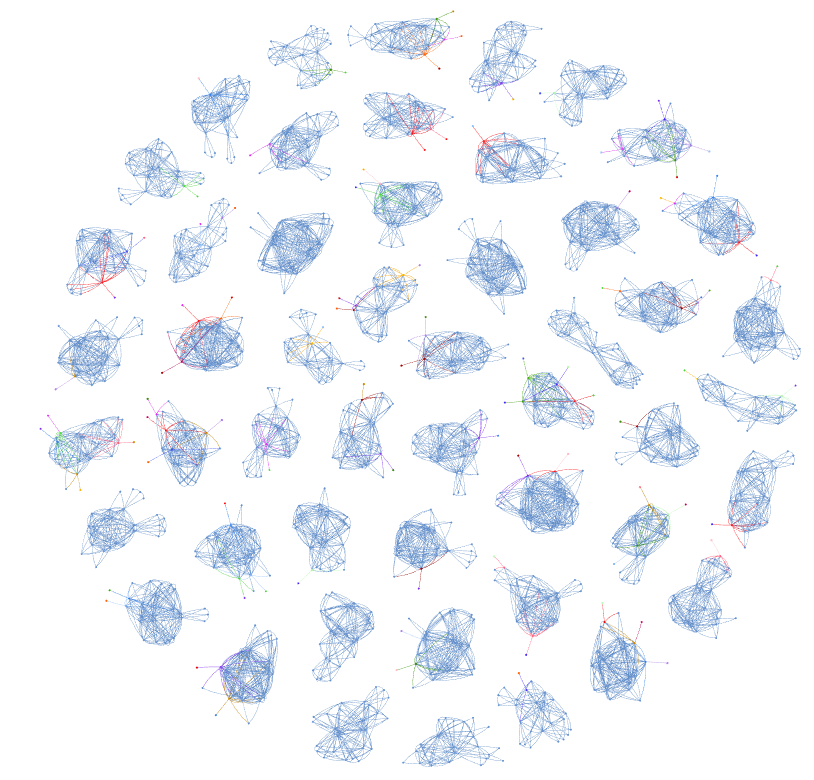

Unique structures:
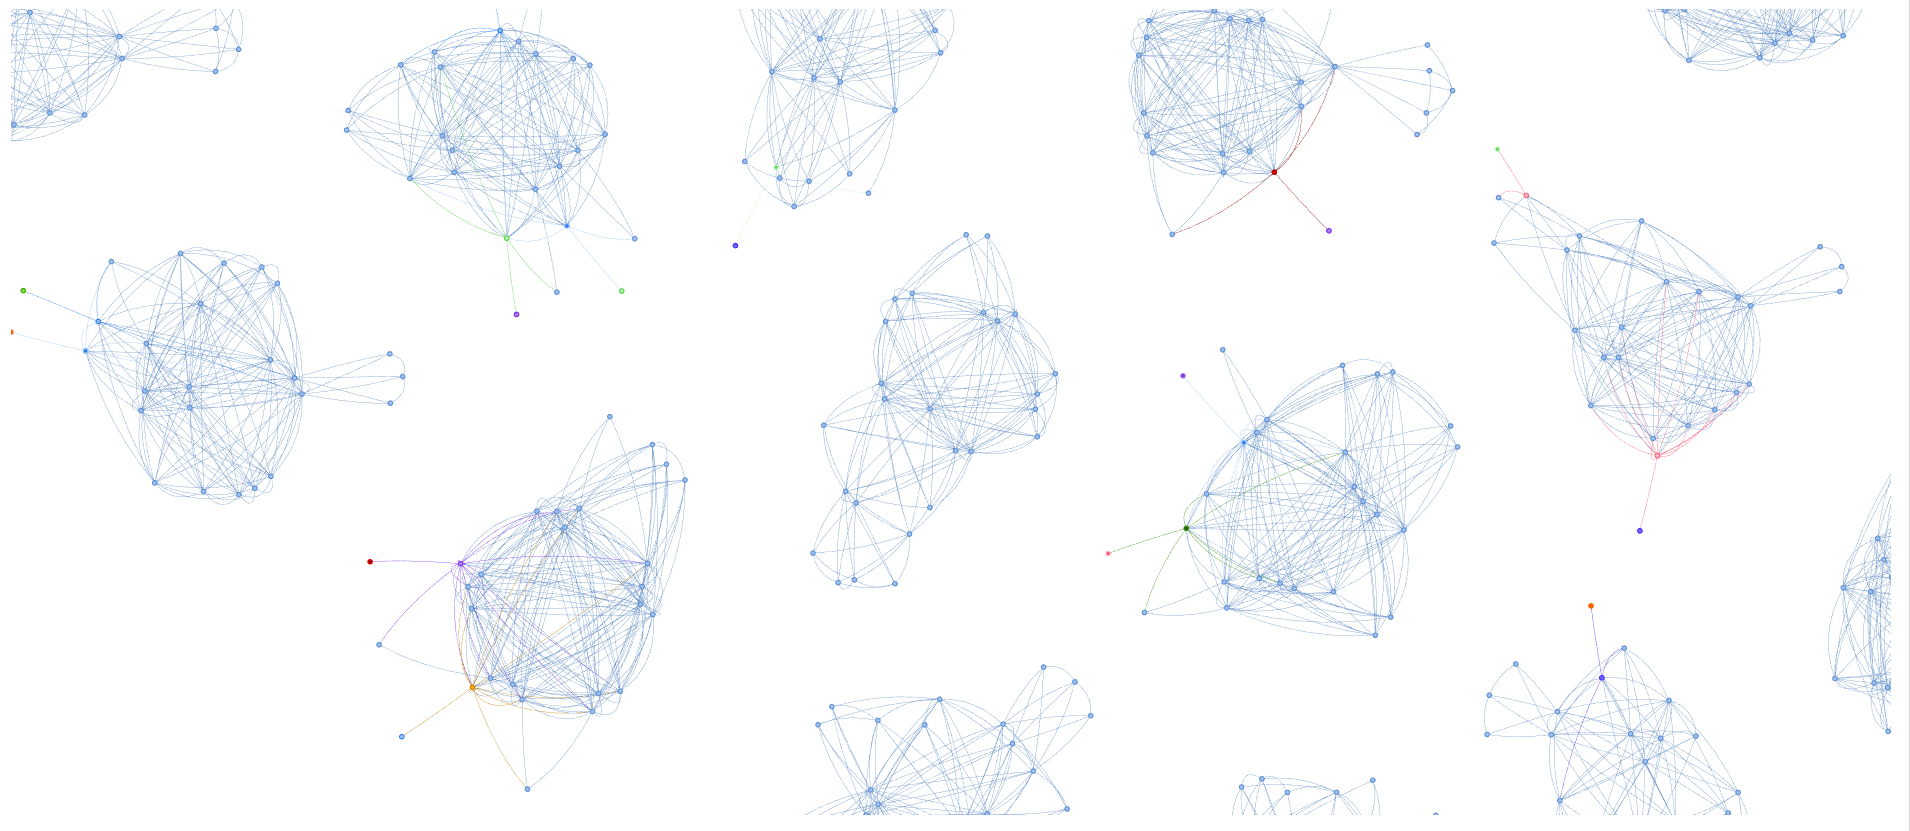